# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you
will need to implement additional functionality to successfully complete this
project. You will not need to modify the included code beyond what is requested.
Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the
following block of code will require additional functionality which you must
provide. Instructions will be provided for each section, and the specifics of
the implementation are marked in the code block with a 'TODO' statement. Please
be sure to read the instructions carefully!

> **Note**: Once you have completed all of the code implementations, you need to
> finalize your work by exporting the iPython Notebook as an HTML document.
> Before exporting the notebook to html, all of the code cells need to have been
> run so that reviewers can see the final implementation and output. You can
> then export the notebook by using the menu above and navigating to \n",
> "**File -> Download as -> HTML (.html)**. Include the finished document along
> with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer
which relate to the project and your implementation. Each section where you will
answer a question is preceded by a **'Question X'** header. Carefully read each
question and provide thorough answers in the following text boxes that begin
with **'Answer:'**. Your project submission will be evaluated based on your
answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter**
>keyboard shortcut. Markdown cells can be edited by double-clicking the cell to
>enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project
beyond the minimum requirements. If you decide to pursue the "Stand Out
Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm
that could be used as part of a mobile or web app. At the end of this project,
your code will accept any user-supplied image as input. If a dog is detected in
the image, it will provide an estimate of the dog's breed. If a human is
detected, it will provide an estimate of the dog breed that is most resembling.
The image below displays potential sample output of your finished project (...
but we expect that each student's algorithm will behave differently!).

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models
to perform different tasks; for instance, the algorithm that detects humans in
an image will be different from the CNN that infers dog breed. There are many
points of possible failure, and no perfect algorithm exists. Your imperfect
solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps. Feel free to use the links below to
navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images. We populate a few
variables through the use of the `load_files` function from the scikit-learn
library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file
  paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing
  onehot-encoded classification labels
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file
paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade
classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html)
to detect human faces in images. OpenCV provides many pre-trained face
detectors, stored as XML files on
[github](https://github.com/opencv/opencv/tree/master/data/haarcascades). We
have downloaded one of these detectors and stored it in the `haarcascades`
directory.

In the next code cell, we demonstrate how to use this detector to find human
faces in a sample image.

Number of faces detected: 1


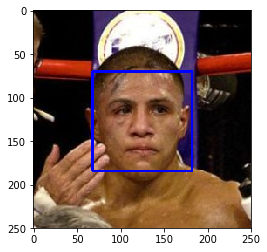

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the
images to grayscale. The `detectMultiScale` function executes the classifier
stored in `face_cascade` and takes the grayscale image as a parameter.

In the above code, `faces` is a numpy array of detected faces, where each row
corresponds to a detected face. Each detected face is a 1D array with four
entries that specifies the bounding box of the detected face. The first two
entries in the array (extracted in the above code as `x` and `y`) specify the
horizontal and vertical positions of the top left corner of the bounding box.
The last two entries in the array (extracted here as `w` and `h`) specify the
width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human
face is detected in an image and `False` otherwise. This function, aptly named
`face_detector`, takes a string-valued file path to an image as input and
appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the
`face_detector` function.
- What percentage of the first 100 images in `human_files` have a detected human
  face? 
- What percentage of the first 100 images in `dog_files` have a detected human
  face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog
images with a detected face. You will see that our algorithm falls short of this
goal, but still gives acceptable performance. We extract the file paths for the
first 100 images from each of the datasets and store them in the numpy arrays
`human_files_short` and `dog_files_short`.

__Answer:__ 

As we can see in the following code snippet, the algorithm detects human faces
98% of pictures with human in them, whereas it detects 11% of human faces in
dog pictures.
 

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

In [7]:
human_classifiation = [face_detector(img_path) for img_path in human_files_short]
dog_classifiation = [face_detector(img_path) for img_path in dog_files_short]

n = len(human_classifiation)
human_rate = sum(human_classifiation)*1.0/n

n = len(dog_classifiation)
dog_rate = sum(dog_classifiation)*1.0/n

print("Rate of human recognition in human pictures in percent: ", 100*human_rate)
print("Rate of human recognition in dog pictures in percent: ", 100*dog_rate)

Rate of human recognition in human pictures in percent:  98.0
Rate of human recognition in dog pictures in percent:  11.0


__Question 2:__ This algorithmic choice necessitates that we communicate to the
user that we accept human images only when they provide a clear view of a face
(otherwise, we risk having unneccessarily frustrated users!). In your opinion,
is this a reasonable expectation to pose on the user? If not, can you think of a
way to detect humans in images that does not necessitate an image with a clearly
presented face?

__Answer:__

This is not a unreasonable expectation to ask to the user. The justification is
users are accustomed to such constraints (for photo pass, selfies and others
apps). Moreover, most users will want to provide clear pictures of themselves,
and when they provide dark and blurry pictures, the users might be amused with
the results of the app, as long as the user can understand that an algorithm can
fail at some questionable input.

If we wanted to improve the algorithm, we could implemented object localization
algorithm where ConvNets are trained with targets combines classification and
objects localization in the pictures.

__End of Answer__

We suggest the face detector from OpenCV as a potential way to detect human
images in your algorithm, but you are free to explore other approaches,
especially approaches that make use of deep learning :). Please use the code
cell below to design and test your own face detection algorithm. If you decide
to pursue this _optional_ task, report performance on each of the datasets.

In [8]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained
[ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006)
model to detect dogs in images. Our first line of code downloads the ResNet-50
model, along with weights that have been trained on
[ImageNet](http://www.image-net.org/), a very large, very popular dataset used
for image classification and other vision tasks. ImageNet contains over 10
million URLs, each linking to an image containing an object from one of [1000
categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an
image, this pre-trained ResNet-50 model returns a prediction (derived from the
available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll
also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and
`rows`, `columns`, and `channels` correspond to the number of rows, columns, and
channels for each image, respectively.

The `path_to_tensor` function below takes a string-valued file path to a color
image as input and returns a 4D tensor suitable for supplying to a Keras CNN.
The function first loads the image and resizes it to a square image that is $224
\times 224$ pixels. Next, the image is converted to an array, which is then
resized to a 4D tensor. In this case, since we are working with color images,
each image has three channels. Likewise, since we are processing a single image
(or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths
as input and returns a 4D tensor with shape

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the
supplied array of image paths. It is best to think of `nb_samples` as the number
of 3D tensors (where each 3D tensor corresponds to a different image) in your
dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model
in Keras, requires some additional processing. First, the RGB image is converted
to BGR by reordering the channels. All pre-trained models have the additional
normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779,
123.68]$ and calculated from all pixels in all images in ImageNet) must be
subtracted from every pixel in each image. This is implemented in the imported
function `preprocess_input`. If you're curious, you can check the code for
`preprocess_input`
[here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are
now ready to use the model to extract the predictions. This is accomplished with
the `predict` method, which returns an array whose $i$-th entry is the model's
predicted probability that the image belongs to the $i$-th ImageNet category.
This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer
corresponding to the model's predicted object class, which we can identify with
an object category through the use of this
[dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [13]:
human_classifiation = [dog_detector(img_path) for img_path in human_files_short]
dog_classifiation = [dog_detector(img_path) for img_path in dog_files_short]

n = len(human_classifiation)
human_rate = sum(human_classifiation)*1.0/n

n = len(dog_classifiation)
dog_rate = sum(dog_classifiation)*1.0/n

print("Rate of dog recognition in human pictures in percent: ", 100*human_rate)
print("Rate of dog recognition in dog pictures in percent: ", 100*dog_rate)

Rate of dog recognition in human pictures in percent:  1.0
Rate of dog recognition in dog pictures in percent:  100.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a
way to predict breed from images. In this step, you will create a CNN that
classifies dog breeds. You must create your CNN _from scratch_ (so, you can't
use transfer learning _yet_!), and you must attain a test accuracy of at least
1%. In Step 5 of this notebook, you will have the opportunity to use transfer
learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers! More parameters means longer
training, which means you are more likely to need a GPU to accelerate the
training process. Thankfully, Keras provides a handy estimate of the time that
each epoch is likely to take; you can extrapolate this estimate to figure out
how long it will take for your algorithm to train.

We mention that the task of assigning breed to dogs from images is considered
exceptionally challenging. To see why, consider that *even a human* would have
great difficulty in distinguishing between a Brittany and a Welsh Springer
Spaniel.

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class
variation (for instance, Curly-Coated Retrievers and American Water Spaniels).

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black. Your
vision-based algorithm will have to conquer this high intra-class variation to
determine how to classify all of these different shades as the same breed.

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting
aside the fact that the classes are slightly imabalanced, a random guess will
provide a correct answer roughly 1 in 133 times, which corresponds to an
accuracy of less than 1%.

Remember that the practice is far ahead of the theory in deep learning.
Experiment with many different architectures, and trust your intuition. And, of
course, have fun!

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

  0%|          | 0/6680 [00:00<?, ?it/s]

  0%|          | 24/6680 [00:00<00:28, 234.82it/s]

  0%|          | 32/6680 [00:00<00:46, 143.13it/s]

  1%|          | 57/6680 [00:00<00:38, 174.14it/s]

  1%|          | 70/6680 [00:00<00:41, 157.66it/s]

  1%|▏         | 88/6680 [00:00<00:40, 161.42it/s]

  2%|▏         | 103/6680 [00:00<00:41, 157.55it/s]

  2%|▏         | 124/6680 [00:00<00:40, 162.49it/s]

  2%|▏         | 141/6680 [00:00<00:43, 149.69it/s]

  2%|▏         | 155/6680 [00:01<00:46, 139.74it/s]

  3%|▎         | 175/6680 [00:01<00:46, 138.69it/s]

  3%|▎         | 200/6680 [00:01<00:44, 146.26it/s]

  3%|▎         | 218/6680 [00:01<00:44, 145.44it/s]

  4%|▎         | 235/6680 [00:01<00:44, 144.23it/s]

  4%|▍         | 256/6680 [00:01<00:43, 147.91it/s]

  4%|▍         | 273/6680 [00:01<00:45, 141.05it/s]

  4%|▍         | 296/6680 [00:02<00:44, 144.74it/s]

  5%|▍         | 313/6680 [00:02<00:44, 143.32it/s]

  5%|▌         | 338/6680 [00:02<00:42, 147.55it/s]

  5%|▌         | 359/6680 [00:02<00:42, 149.55it/s]

  6%|▌         | 377/6680 [00:02<00:44, 140.53it/s]

  6%|▌         | 392/6680 [00:02<00:45, 136.76it/s]

  6%|▌         | 406/6680 [00:02<00:45, 136.71it/s]

  6%|▋         | 425/6680 [00:03<00:45, 137.63it/s]

  7%|▋         | 447/6680 [00:03<00:46, 135.39it/s]

  7%|▋         | 460/6680 [00:03<00:46, 133.34it/s]

  7%|▋         | 477/6680 [00:03<00:46, 134.33it/s]

  7%|▋         | 491/6680 [00:03<00:47, 129.13it/s]

  8%|▊         | 513/6680 [00:03<00:46, 131.44it/s]

  8%|▊         | 528/6680 [00:04<00:46, 131.44it/s]

  8%|▊         | 544/6680 [00:04<00:47, 130.15it/s]

  8%|▊         | 562/6680 [00:04<00:46, 131.30it/s]

  9%|▊         | 577/6680 [00:04<00:46, 130.12it/s]

  9%|▉         | 590/6680 [00:04<00:47, 129.48it/s]

  9%|▉         | 611/6680 [00:04<00:46, 131.19it/s]

  9%|▉         | 629/6680 [00:04<00:45, 131.89it/s]

 10%|▉         | 645/6680 [00:04<00:46, 130.89it/s]

 10%|▉         | 663/6680 [00:05<00:45, 131.65it/s]

 10%|█         | 687/6680 [00:05<00:44, 133.75it/s]

 11%|█         | 706/6680 [00:05<00:44, 134.73it/s]

 11%|█         | 724/6680 [00:05<00:44, 133.52it/s]

 11%|█         | 745/6680 [00:05<00:44, 134.81it/s]

 11%|█▏        | 762/6680 [00:05<00:43, 134.57it/s]

 12%|█▏        | 787/6680 [00:05<00:43, 136.53it/s]

 12%|█▏        | 806/6680 [00:05<00:42, 137.42it/s]

 12%|█▏        | 825/6680 [00:06<00:42, 136.29it/s]

 13%|█▎        | 841/6680 [00:06<00:42, 136.60it/s]

 13%|█▎        | 860/6680 [00:06<00:42, 137.45it/s]

 13%|█▎        | 877/6680 [00:06<00:42, 137.44it/s]

 13%|█▎        | 894/6680 [00:06<00:42, 137.53it/s]

 14%|█▎        | 910/6680 [00:06<00:42, 134.47it/s]

 14%|█▍        | 923/6680 [00:06<00:42, 134.34it/s]

 14%|█▍        | 940/6680 [00:06<00:42, 134.78it/s]

 14%|█▍        | 959/6680 [00:07<00:42, 135.52it/s]

 15%|█▍        | 975/6680 [00:07<00:42, 133.08it/s]

 15%|█▍        | 997/6680 [00:07<00:42, 134.23it/s]

 15%|█▌        | 1013/6680 [00:07<00:42, 134.13it/s]

 15%|█▌        | 1028/6680 [00:07<00:42, 132.80it/s]

 16%|█▌        | 1041/6680 [00:07<00:42, 131.94it/s]

 16%|█▌        | 1063/6680 [00:07<00:42, 132.89it/s]

 16%|█▌        | 1078/6680 [00:08<00:42, 132.99it/s]

 16%|█▋        | 1097/6680 [00:08<00:41, 133.64it/s]

 17%|█▋        | 1113/6680 [00:08<00:41, 133.96it/s]

 17%|█▋        | 1129/6680 [00:08<00:42, 130.93it/s]

 17%|█▋        | 1150/6680 [00:08<00:41, 131.68it/s]

 17%|█▋        | 1165/6680 [00:08<00:41, 131.56it/s]

 18%|█▊        | 1179/6680 [00:08<00:41, 131.07it/s]

 18%|█▊        | 1197/6680 [00:09<00:41, 131.47it/s]

 18%|█▊        | 1211/6680 [00:09<00:41, 130.80it/s]

 18%|█▊        | 1226/6680 [00:09<00:41, 130.94it/s]

 19%|█▊        | 1245/6680 [00:09<00:41, 131.53it/s]

 19%|█▉        | 1260/6680 [00:09<00:41, 130.71it/s]

 19%|█▉        | 1277/6680 [00:09<00:41, 131.10it/s]

 20%|█▉        | 1303/6680 [00:09<00:40, 132.40it/s]

 20%|█▉        | 1327/6680 [00:09<00:40, 133.08it/s]

 20%|██        | 1345/6680 [00:10<00:40, 132.17it/s]

 20%|██        | 1361/6680 [00:10<00:40, 131.46it/s]

 21%|██        | 1380/6680 [00:10<00:40, 132.00it/s]

 21%|██        | 1395/6680 [00:10<00:40, 131.68it/s]

 21%|██        | 1409/6680 [00:10<00:40, 131.40it/s]

 21%|██▏       | 1423/6680 [00:10<00:39, 131.47it/s]

 22%|██▏       | 1444/6680 [00:10<00:39, 132.17it/s]

 22%|██▏       | 1460/6680 [00:11<00:39, 131.46it/s]

 22%|██▏       | 1482/6680 [00:11<00:39, 132.13it/s]

 23%|██▎       | 1506/6680 [00:11<00:38, 133.05it/s]

 23%|██▎       | 1528/6680 [00:11<00:38, 133.54it/s]

 23%|██▎       | 1547/6680 [00:11<00:38, 133.75it/s]

 23%|██▎       | 1565/6680 [00:11<00:38, 132.78it/s]

 24%|██▎       | 1583/6680 [00:11<00:38, 133.04it/s]

 24%|██▍       | 1598/6680 [00:12<00:38, 132.71it/s]

 24%|██▍       | 1612/6680 [00:12<00:38, 132.26it/s]

 24%|██▍       | 1631/6680 [00:12<00:38, 132.71it/s]

 25%|██▍       | 1647/6680 [00:12<00:37, 132.91it/s]

 25%|██▌       | 1670/6680 [00:12<00:37, 133.65it/s]

 25%|██▌       | 1687/6680 [00:12<00:37, 132.23it/s]

 26%|██▌       | 1712/6680 [00:12<00:37, 133.11it/s]

 26%|██▌       | 1732/6680 [00:13<00:37, 132.92it/s]

 26%|██▋       | 1755/6680 [00:13<00:36, 133.58it/s]

 27%|██▋       | 1773/6680 [00:13<00:36, 133.87it/s]

 27%|██▋       | 1791/6680 [00:13<00:36, 133.94it/s]

 27%|██▋       | 1815/6680 [00:13<00:36, 134.70it/s]

 27%|██▋       | 1834/6680 [00:13<00:36, 134.41it/s]

 28%|██▊       | 1852/6680 [00:13<00:35, 134.70it/s]

 28%|██▊       | 1869/6680 [00:13<00:35, 134.32it/s]

 28%|██▊       | 1890/6680 [00:14<00:35, 134.84it/s]

 29%|██▊       | 1907/6680 [00:14<00:35, 134.49it/s]

 29%|██▉       | 1928/6680 [00:14<00:35, 134.54it/s]

 29%|██▉       | 1948/6680 [00:14<00:35, 134.98it/s]

 30%|██▉       | 1974/6680 [00:14<00:34, 135.82it/s]

 30%|██▉       | 1993/6680 [00:14<00:34, 136.15it/s]

 30%|███       | 2012/6680 [00:15<00:35, 132.07it/s]

 30%|███       | 2029/6680 [00:15<00:35, 132.31it/s]

 31%|███       | 2044/6680 [00:15<00:35, 132.26it/s]

 31%|███       | 2060/6680 [00:15<00:34, 132.36it/s]

 31%|███       | 2075/6680 [00:15<00:34, 132.33it/s]

 31%|███▏      | 2098/6680 [00:15<00:34, 132.93it/s]

 32%|███▏      | 2115/6680 [00:15<00:34, 133.02it/s]

 32%|███▏      | 2138/6680 [00:16<00:33, 133.62it/s]

 32%|███▏      | 2156/6680 [00:16<00:33, 133.75it/s]

 33%|███▎      | 2174/6680 [00:16<00:33, 134.00it/s]

 33%|███▎      | 2192/6680 [00:16<00:33, 133.96it/s]

 33%|███▎      | 2210/6680 [00:16<00:33, 134.23it/s]

 33%|███▎      | 2227/6680 [00:16<00:33, 134.09it/s]

 34%|███▎      | 2254/6680 [00:16<00:32, 134.89it/s]

 34%|███▍      | 2273/6680 [00:17<00:33, 133.21it/s]

 34%|███▍      | 2291/6680 [00:17<00:32, 133.48it/s]

 35%|███▍      | 2307/6680 [00:17<00:32, 133.54it/s]

 35%|███▍      | 2323/6680 [00:17<00:32, 133.34it/s]

 35%|███▍      | 2337/6680 [00:17<00:32, 132.63it/s]

 35%|███▌      | 2349/6680 [00:17<00:32, 132.02it/s]

 35%|███▌      | 2360/6680 [00:17<00:32, 131.68it/s]

 36%|███▌      | 2376/6680 [00:18<00:32, 131.84it/s]

 36%|███▌      | 2399/6680 [00:18<00:32, 132.38it/s]

 36%|███▌      | 2416/6680 [00:18<00:32, 132.56it/s]

 36%|███▋      | 2433/6680 [00:18<00:32, 132.72it/s]

 37%|███▋      | 2454/6680 [00:18<00:31, 132.73it/s]

 37%|███▋      | 2469/6680 [00:18<00:31, 132.47it/s]

 37%|███▋      | 2490/6680 [00:18<00:31, 132.87it/s]

 38%|███▊      | 2513/6680 [00:18<00:31, 133.36it/s]

 38%|███▊      | 2533/6680 [00:18<00:31, 133.70it/s]

 38%|███▊      | 2552/6680 [00:19<00:30, 133.84it/s]

 38%|███▊      | 2570/6680 [00:19<00:30, 133.49it/s]

 39%|███▊      | 2586/6680 [00:19<00:30, 133.54it/s]

 39%|███▉      | 2603/6680 [00:19<00:30, 133.72it/s]

 39%|███▉      | 2619/6680 [00:19<00:30, 133.67it/s]

 39%|███▉      | 2634/6680 [00:19<00:30, 133.62it/s]

 40%|███▉      | 2649/6680 [00:19<00:30, 133.52it/s]

 40%|███▉      | 2665/6680 [00:19<00:30, 133.45it/s]

 40%|████      | 2683/6680 [00:20<00:29, 133.57it/s]

 41%|████      | 2707/6680 [00:20<00:29, 133.40it/s]

 41%|████      | 2725/6680 [00:20<00:29, 133.63it/s]

 41%|████      | 2747/6680 [00:20<00:29, 134.04it/s]

 41%|████▏     | 2769/6680 [00:20<00:29, 134.45it/s]

 42%|████▏     | 2788/6680 [00:20<00:28, 134.28it/s]

 42%|████▏     | 2805/6680 [00:21<00:29, 133.14it/s]

 42%|████▏     | 2822/6680 [00:21<00:28, 133.31it/s]

 43%|████▎     | 2844/6680 [00:21<00:28, 133.71it/s]

 43%|████▎     | 2861/6680 [00:21<00:28, 133.61it/s]

 43%|████▎     | 2877/6680 [00:21<00:28, 133.04it/s]

 43%|████▎     | 2895/6680 [00:21<00:28, 132.32it/s]

 44%|████▎     | 2910/6680 [00:21<00:28, 132.40it/s]

 44%|████▍     | 2930/6680 [00:22<00:28, 132.68it/s]

 44%|████▍     | 2952/6680 [00:22<00:28, 133.08it/s]

 45%|████▍     | 2974/6680 [00:22<00:27, 133.35it/s]

 45%|████▍     | 2992/6680 [00:22<00:27, 133.28it/s]

 45%|████▌     | 3008/6680 [00:22<00:27, 133.36it/s]

 45%|████▌     | 3029/6680 [00:22<00:27, 133.67it/s]

 46%|████▌     | 3048/6680 [00:22<00:27, 133.89it/s]

 46%|████▌     | 3066/6680 [00:22<00:27, 133.53it/s]

 46%|████▌     | 3084/6680 [00:23<00:26, 133.73it/s]

 46%|████▋     | 3100/6680 [00:23<00:26, 133.30it/s]

 47%|████▋     | 3114/6680 [00:23<00:26, 132.43it/s]

 47%|████▋     | 3127/6680 [00:23<00:26, 132.40it/s]

 47%|████▋     | 3147/6680 [00:23<00:26, 132.63it/s]

 47%|████▋     | 3161/6680 [00:23<00:26, 132.23it/s]

 48%|████▊     | 3173/6680 [00:24<00:26, 132.03it/s]

 48%|████▊     | 3185/6680 [00:24<00:26, 131.89it/s]

 48%|████▊     | 3196/6680 [00:24<00:26, 131.58it/s]

 48%|████▊     | 3213/6680 [00:24<00:26, 131.73it/s]

 48%|████▊     | 3226/6680 [00:24<00:26, 130.95it/s]

 49%|████▊     | 3246/6680 [00:24<00:26, 131.22it/s]

 49%|████▉     | 3260/6680 [00:24<00:26, 131.23it/s]

 49%|████▉     | 3274/6680 [00:25<00:26, 130.65it/s]

 49%|████▉     | 3292/6680 [00:25<00:25, 130.76it/s]

 50%|████▉     | 3312/6680 [00:25<00:25, 131.02it/s]

 50%|████▉     | 3327/6680 [00:25<00:25, 130.98it/s]

 50%|█████     | 3341/6680 [00:25<00:25, 130.72it/s]

 50%|█████     | 3363/6680 [00:25<00:25, 131.07it/s]

 51%|█████     | 3379/6680 [00:25<00:25, 131.15it/s]

 51%|█████     | 3397/6680 [00:25<00:25, 130.75it/s]

 51%|█████     | 3417/6680 [00:26<00:24, 131.00it/s]

 51%|█████▏    | 3433/6680 [00:26<00:24, 131.10it/s]

 52%|█████▏    | 3449/6680 [00:26<00:24, 130.95it/s]

 52%|█████▏    | 3469/6680 [00:26<00:24, 131.20it/s]

 52%|█████▏    | 3491/6680 [00:26<00:24, 131.45it/s]

 53%|█████▎    | 3512/6680 [00:26<00:24, 131.66it/s]

 53%|█████▎    | 3529/6680 [00:26<00:23, 131.57it/s]

 53%|█████▎    | 3545/6680 [00:27<00:23, 131.29it/s]

 53%|█████▎    | 3569/6680 [00:27<00:23, 131.68it/s]

 54%|█████▍    | 3592/6680 [00:27<00:23, 132.02it/s]

 54%|█████▍    | 3615/6680 [00:27<00:23, 132.33it/s]

 54%|█████▍    | 3637/6680 [00:27<00:22, 132.64it/s]

 55%|█████▍    | 3660/6680 [00:27<00:22, 132.99it/s]

 55%|█████▌    | 3681/6680 [00:27<00:22, 132.92it/s]

 55%|█████▌    | 3700/6680 [00:27<00:22, 133.00it/s]

 56%|█████▌    | 3718/6680 [00:27<00:22, 132.86it/s]

 56%|█████▌    | 3741/6680 [00:28<00:22, 133.18it/s]

 56%|█████▋    | 3759/6680 [00:28<00:21, 133.29it/s]

 57%|█████▋    | 3776/6680 [00:28<00:21, 133.19it/s]

 57%|█████▋    | 3792/6680 [00:28<00:21, 133.24it/s]

 57%|█████▋    | 3808/6680 [00:28<00:21, 133.04it/s]

 57%|█████▋    | 3826/6680 [00:28<00:21, 133.00it/s]

 58%|█████▊    | 3853/6680 [00:28<00:21, 133.44it/s]

 58%|█████▊    | 3870/6680 [00:29<00:21, 133.22it/s]

 58%|█████▊    | 3896/6680 [00:29<00:20, 133.61it/s]

 59%|█████▊    | 3914/6680 [00:29<00:20, 132.72it/s]

 59%|█████▉    | 3928/6680 [00:29<00:20, 132.51it/s]

 59%|█████▉    | 3941/6680 [00:29<00:20, 132.35it/s]

 59%|█████▉    | 3962/6680 [00:29<00:20, 132.60it/s]

 60%|█████▉    | 3978/6680 [00:29<00:20, 132.69it/s]

 60%|█████▉    | 3993/6680 [00:30<00:20, 132.71it/s]

 60%|██████    | 4015/6680 [00:30<00:20, 132.98it/s]

 60%|██████    | 4037/6680 [00:30<00:19, 133.25it/s]

 61%|██████    | 4055/6680 [00:30<00:19, 133.32it/s]

 61%|██████    | 4076/6680 [00:30<00:19, 133.55it/s]

 61%|██████▏   | 4094/6680 [00:30<00:19, 133.24it/s]

 62%|██████▏   | 4112/6680 [00:30<00:19, 133.34it/s]

 62%|██████▏   | 4128/6680 [00:30<00:19, 133.40it/s]

 62%|██████▏   | 4144/6680 [00:31<00:19, 133.30it/s]

 62%|██████▏   | 4161/6680 [00:31<00:18, 133.40it/s]

 63%|██████▎   | 4176/6680 [00:31<00:18, 133.08it/s]

 63%|██████▎   | 4194/6680 [00:31<00:18, 133.22it/s]

 63%|██████▎   | 4209/6680 [00:31<00:18, 132.80it/s]

 63%|██████▎   | 4229/6680 [00:31<00:18, 133.00it/s]

 64%|██████▎   | 4246/6680 [00:31<00:18, 133.04it/s]

 64%|██████▍   | 4261/6680 [00:32<00:18, 132.78it/s]

 64%|██████▍   | 4285/6680 [00:32<00:18, 133.03it/s]

 64%|██████▍   | 4300/6680 [00:32<00:17, 132.85it/s]

 65%|██████▍   | 4323/6680 [00:32<00:17, 133.15it/s]

 65%|██████▌   | 4346/6680 [00:32<00:17, 133.45it/s]

 65%|██████▌   | 4365/6680 [00:32<00:17, 133.26it/s]

 66%|██████▌   | 4381/6680 [00:32<00:17, 133.09it/s]

 66%|██████▌   | 4405/6680 [00:33<00:17, 133.41it/s]

 66%|██████▌   | 4422/6680 [00:33<00:16, 132.98it/s]

 67%|██████▋   | 4443/6680 [00:33<00:16, 133.20it/s]

 67%|██████▋   | 4465/6680 [00:33<00:16, 133.44it/s]

 67%|██████▋   | 4483/6680 [00:33<00:16, 133.26it/s]

 67%|██████▋   | 4500/6680 [00:33<00:16, 133.36it/s]

 68%|██████▊   | 4516/6680 [00:33<00:16, 133.40it/s]

 68%|██████▊   | 4532/6680 [00:34<00:16, 133.27it/s]

 68%|██████▊   | 4546/6680 [00:34<00:16, 132.55it/s]

 68%|██████▊   | 4564/6680 [00:34<00:15, 132.67it/s]

 69%|██████▊   | 4586/6680 [00:34<00:15, 132.92it/s]

 69%|██████▉   | 4607/6680 [00:34<00:15, 133.14it/s]

 69%|██████▉   | 4625/6680 [00:34<00:15, 133.13it/s]

 69%|██████▉   | 4641/6680 [00:34<00:15, 133.10it/s]

 70%|██████▉   | 4661/6680 [00:34<00:15, 133.29it/s]

 70%|███████   | 4678/6680 [00:35<00:15, 133.15it/s]

 70%|███████   | 4693/6680 [00:35<00:14, 133.06it/s]

 71%|███████   | 4712/6680 [00:35<00:14, 133.20it/s]

 71%|███████   | 4738/6680 [00:35<00:14, 133.54it/s]

 71%|███████   | 4756/6680 [00:35<00:14, 133.38it/s]

 71%|███████▏  | 4776/6680 [00:35<00:14, 133.55it/s]

 72%|███████▏  | 4795/6680 [00:35<00:14, 133.67it/s]

 72%|███████▏  | 4812/6680 [00:36<00:13, 133.60it/s]

 72%|███████▏  | 4831/6680 [00:36<00:13, 133.75it/s]

 73%|███████▎  | 4851/6680 [00:36<00:13, 133.93it/s]

 73%|███████▎  | 4869/6680 [00:36<00:13, 133.90it/s]

 73%|███████▎  | 4885/6680 [00:36<00:13, 133.79it/s]

 73%|███████▎  | 4903/6680 [00:36<00:13, 133.90it/s]

 74%|███████▎  | 4924/6680 [00:36<00:13, 134.07it/s]

 74%|███████▍  | 4945/6680 [00:36<00:12, 134.26it/s]

 74%|███████▍  | 4964/6680 [00:36<00:12, 134.38it/s]

 75%|███████▍  | 4986/6680 [00:37<00:12, 134.60it/s]

 75%|███████▍  | 5005/6680 [00:37<00:12, 134.63it/s]

 75%|███████▌  | 5029/6680 [00:37<00:12, 134.90it/s]

 76%|███████▌  | 5049/6680 [00:37<00:12, 135.03it/s]

 76%|███████▌  | 5068/6680 [00:37<00:11, 135.11it/s]

 76%|███████▌  | 5086/6680 [00:37<00:11, 134.91it/s]

 76%|███████▋  | 5102/6680 [00:37<00:11, 134.93it/s]

 77%|███████▋  | 5118/6680 [00:38<00:11, 134.26it/s]

 77%|███████▋  | 5131/6680 [00:38<00:11, 134.10it/s]

 77%|███████▋  | 5152/6680 [00:38<00:11, 134.28it/s]

 77%|███████▋  | 5169/6680 [00:38<00:11, 134.33it/s]

 78%|███████▊  | 5184/6680 [00:38<00:11, 134.36it/s]

 78%|███████▊  | 5203/6680 [00:38<00:10, 134.49it/s]

 78%|███████▊  | 5224/6680 [00:38<00:10, 134.67it/s]

 78%|███████▊  | 5243/6680 [00:38<00:10, 134.81it/s]

 79%|███████▉  | 5261/6680 [00:39<00:10, 134.84it/s]

 79%|███████▉  | 5278/6680 [00:39<00:10, 134.89it/s]

 79%|███████▉  | 5295/6680 [00:39<00:10, 134.61it/s]

 80%|███████▉  | 5318/6680 [00:39<00:10, 134.82it/s]

 80%|███████▉  | 5335/6680 [00:39<00:09, 134.90it/s]

 80%|████████  | 5352/6680 [00:39<00:09, 134.84it/s]

 80%|████████  | 5375/6680 [00:39<00:09, 135.07it/s]

 81%|████████  | 5393/6680 [00:39<00:09, 134.98it/s]

 81%|████████  | 5409/6680 [00:40<00:09, 134.94it/s]

 81%|████████▏ | 5433/6680 [00:40<00:09, 135.19it/s]

 82%|████████▏ | 5451/6680 [00:40<00:09, 135.15it/s]

 82%|████████▏ | 5473/6680 [00:40<00:08, 135.36it/s]

 82%|████████▏ | 5496/6680 [00:40<00:08, 135.58it/s]

 83%|████████▎ | 5515/6680 [00:40<00:08, 135.56it/s]

 83%|████████▎ | 5533/6680 [00:40<00:08, 135.64it/s]

 83%|████████▎ | 5556/6680 [00:40<00:08, 135.87it/s]

 84%|████████▎ | 5578/6680 [00:40<00:08, 136.06it/s]

 84%|████████▍ | 5598/6680 [00:41<00:07, 135.42it/s]

 84%|████████▍ | 5616/6680 [00:41<00:07, 135.53it/s]

 84%|████████▍ | 5633/6680 [00:41<00:07, 135.60it/s]

 85%|████████▍ | 5650/6680 [00:41<00:07, 135.59it/s]

 85%|████████▍ | 5666/6680 [00:41<00:07, 135.29it/s]

 85%|████████▌ | 5683/6680 [00:41<00:07, 135.38it/s]

 85%|████████▌ | 5700/6680 [00:42<00:07, 135.42it/s]

 86%|████████▌ | 5715/6680 [00:42<00:07, 135.19it/s]

 86%|████████▌ | 5736/6680 [00:42<00:06, 135.36it/s]

 86%|████████▌ | 5751/6680 [00:42<00:06, 135.36it/s]

 86%|████████▋ | 5768/6680 [00:42<00:06, 135.40it/s]

 87%|████████▋ | 5798/6680 [00:42<00:06, 135.58it/s]

 87%|████████▋ | 5821/6680 [00:42<00:06, 135.79it/s]

 87%|████████▋ | 5839/6680 [00:43<00:06, 135.70it/s]

 88%|████████▊ | 5855/6680 [00:43<00:06, 135.35it/s]

 88%|████████▊ | 5869/6680 [00:43<00:05, 135.31it/s]

 88%|████████▊ | 5889/6680 [00:43<00:05, 135.46it/s]

 88%|████████▊ | 5911/6680 [00:43<00:05, 135.64it/s]

 89%|████████▉ | 5929/6680 [00:43<00:05, 135.74it/s]

 89%|████████▉ | 5947/6680 [00:43<00:05, 135.63it/s]

 89%|████████▉ | 5968/6680 [00:43<00:05, 135.79it/s]

 90%|████████▉ | 5985/6680 [00:44<00:05, 135.59it/s]

 90%|████████▉ | 6007/6680 [00:44<00:04, 135.78it/s]

 90%|█████████ | 6030/6680 [00:44<00:04, 135.97it/s]

 91%|█████████ | 6049/6680 [00:44<00:04, 136.09it/s]

 91%|█████████ | 6068/6680 [00:44<00:04, 136.06it/s]

 91%|█████████ | 6085/6680 [00:44<00:04, 136.11it/s]

 91%|█████████▏| 6109/6680 [00:44<00:04, 136.34it/s]

 92%|█████████▏| 6129/6680 [00:44<00:04, 136.45it/s]

 92%|█████████▏| 6148/6680 [00:45<00:03, 136.52it/s]

 92%|█████████▏| 6166/6680 [00:45<00:03, 136.17it/s]

 93%|█████████▎| 6181/6680 [00:45<00:03, 136.18it/s]

 93%|█████████▎| 6202/6680 [00:45<00:03, 136.34it/s]

 93%|█████████▎| 6219/6680 [00:45<00:03, 136.02it/s]

 93%|█████████▎| 6238/6680 [00:45<00:03, 136.13it/s]

 94%|█████████▎| 6254/6680 [00:45<00:03, 136.18it/s]

 94%|█████████▍| 6272/6680 [00:46<00:02, 136.27it/s]

 94%|█████████▍| 6289/6680 [00:46<00:02, 136.10it/s]

 94%|█████████▍| 6307/6680 [00:46<00:02, 136.19it/s]

 95%|█████████▍| 6323/6680 [00:46<00:02, 136.01it/s]

 95%|█████████▍| 6340/6680 [00:46<00:02, 136.08it/s]

 95%|█████████▌| 6355/6680 [00:46<00:02, 136.07it/s]

 95%|█████████▌| 6374/6680 [00:46<00:02, 135.87it/s]

 96%|█████████▌| 6392/6680 [00:47<00:02, 135.95it/s]

 96%|█████████▌| 6406/6680 [00:47<00:02, 135.42it/s]

 96%|█████████▌| 6419/6680 [00:47<00:01, 135.15it/s]

 96%|█████████▋| 6440/6680 [00:47<00:01, 135.30it/s]

 97%|█████████▋| 6455/6680 [00:47<00:01, 135.33it/s]

 97%|█████████▋| 6469/6680 [00:47<00:01, 135.27it/s]

 97%|█████████▋| 6494/6680 [00:47<00:01, 135.31it/s]

 97%|█████████▋| 6508/6680 [00:48<00:01, 135.05it/s]

 98%|█████████▊| 6520/6680 [00:48<00:01, 134.67it/s]

 98%|█████████▊| 6530/6680 [00:48<00:01, 134.45it/s]

 98%|█████████▊| 6543/6680 [00:48<00:01, 134.42it/s]

 98%|█████████▊| 6559/6680 [00:48<00:00, 134.46it/s]

 98%|█████████▊| 6577/6680 [00:48<00:00, 134.55it/s]

 99%|█████████▉| 6598/6680 [00:48<00:00, 134.69it/s]

 99%|█████████▉| 6614/6680 [00:49<00:00, 134.61it/s]

 99%|█████████▉| 6629/6680 [00:49<00:00, 134.38it/s]

100%|█████████▉| 6654/6680 [00:49<00:00, 134.19it/s]

100%|█████████▉| 6672/6680 [00:49<00:00, 133.94it/s]

100%|██████████| 6680/6680 [00:49<00:00, 133.99it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 3/835 [00:00<00:34, 24.26it/s]

  2%|▏         | 19/835 [00:00<00:09, 84.30it/s]

  5%|▍         | 38/835 [00:00<00:06, 116.40it/s]

  6%|▋         | 54/835 [00:00<00:06, 126.47it/s]

  8%|▊         | 70/835 [00:00<00:05, 132.74it/s]

 10%|█         | 84/835 [00:00<00:05, 132.39it/s]

 12%|█▏        | 101/835 [00:00<00:05, 128.13it/s]

 14%|█▎        | 114/835 [00:00<00:05, 121.93it/s]

 15%|█▌        | 126/835 [00:01<00:06, 112.47it/s]

 17%|█▋        | 143/835 [00:01<00:05, 117.00it/s]

 19%|█▉        | 159/835 [00:01<00:05, 120.05it/s]

 21%|██        | 173/835 [00:01<00:05, 120.33it/s]

 23%|██▎       | 192/835 [00:01<00:05, 123.81it/s]

 25%|██▌       | 209/835 [00:01<00:04, 126.50it/s]

 27%|██▋       | 226/835 [00:01<00:04, 128.04it/s]

 29%|██▉       | 244/835 [00:01<00:04, 125.42it/s]

 31%|███       | 260/835 [00:02<00:04, 126.14it/s]

 33%|███▎      | 279/835 [00:02<00:04, 129.06it/s]

 37%|███▋      | 307/835 [00:02<00:03, 135.69it/s]

 39%|███▉      | 328/835 [00:02<00:03, 138.28it/s]

 42%|████▏     | 348/835 [00:02<00:03, 140.64it/s]

 44%|████▍     | 371/835 [00:02<00:03, 143.17it/s]

 47%|████▋     | 391/835 [00:02<00:03, 145.24it/s]

 49%|████▉     | 411/835 [00:02<00:02, 144.32it/s]

 52%|█████▏    | 434/835 [00:02<00:02, 147.20it/s]

 54%|█████▍    | 454/835 [00:03<00:02, 148.59it/s]

 57%|█████▋    | 474/835 [00:03<00:02, 149.20it/s]

 60%|█████▉    | 498/835 [00:03<00:02, 151.97it/s]

 62%|██████▏   | 519/835 [00:03<00:02, 146.23it/s]

 64%|██████▍   | 536/835 [00:03<00:02, 146.13it/s]

 67%|██████▋   | 559/835 [00:03<00:01, 148.29it/s]

 69%|██████▉   | 580/835 [00:03<00:01, 149.76it/s]

 72%|███████▏  | 599/835 [00:03<00:01, 150.13it/s]

 74%|███████▍  | 617/835 [00:04<00:01, 149.23it/s]

 76%|███████▋  | 638/835 [00:04<00:01, 150.53it/s]

 79%|███████▊  | 656/835 [00:04<00:01, 146.49it/s]

 80%|████████  | 671/835 [00:04<00:01, 143.03it/s]

 82%|████████▏ | 687/835 [00:04<00:01, 143.17it/s]

 85%|████████▍ | 707/835 [00:04<00:00, 144.32it/s]

 87%|████████▋ | 723/835 [00:05<00:00, 144.08it/s]

 89%|████████▉ | 743/835 [00:05<00:00, 145.16it/s]

 91%|█████████ | 760/835 [00:05<00:00, 145.29it/s]

 94%|█████████▎| 782/835 [00:05<00:00, 146.58it/s]

 96%|█████████▌| 802/835 [00:05<00:00, 147.53it/s]

 98%|█████████▊| 821/835 [00:05<00:00, 147.24it/s]

100%|██████████| 835/835 [00:05<00:00, 148.20it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

  3%|▎         | 24/836 [00:00<00:03, 233.16it/s]

  6%|▌         | 47/836 [00:00<00:04, 166.38it/s]

  7%|▋         | 60/836 [00:00<00:05, 154.66it/s]

  9%|▉         | 74/836 [00:00<00:05, 144.76it/s]

 11%|█▏        | 95/836 [00:00<00:04, 153.90it/s]

 13%|█▎        | 112/836 [00:00<00:04, 153.75it/s]

 16%|█▌        | 132/836 [00:00<00:04, 158.94it/s]

 18%|█▊        | 148/836 [00:01<00:04, 145.25it/s]

 20%|█▉        | 167/836 [00:01<00:04, 149.16it/s]

 22%|██▏       | 187/836 [00:01<00:04, 152.74it/s]

 25%|██▌       | 209/836 [00:01<00:03, 157.50it/s]

 27%|██▋       | 228/836 [00:01<00:03, 159.50it/s]

 30%|██▉       | 247/836 [00:01<00:03, 159.14it/s]

 32%|███▏      | 269/836 [00:01<00:03, 162.48it/s]

 34%|███▍      | 288/836 [00:01<00:03, 160.39it/s]

 37%|███▋      | 308/836 [00:01<00:03, 162.09it/s]

 40%|███▉      | 333/836 [00:02<00:03, 166.29it/s]

 42%|████▏     | 353/836 [00:02<00:03, 159.28it/s]

 44%|████▍     | 370/836 [00:02<00:02, 155.44it/s]

 46%|████▋     | 388/836 [00:02<00:02, 156.31it/s]

 49%|████▊     | 407/836 [00:02<00:02, 157.53it/s]

 51%|█████     | 424/836 [00:02<00:02, 157.65it/s]

 53%|█████▎    | 441/836 [00:02<00:02, 156.48it/s]

 55%|█████▍    | 457/836 [00:02<00:02, 154.36it/s]

 57%|█████▋    | 476/836 [00:03<00:02, 155.38it/s]

 59%|█████▉    | 495/836 [00:03<00:02, 156.38it/s]

 62%|██████▏   | 518/836 [00:03<00:02, 158.47it/s]

 64%|██████▍   | 537/836 [00:03<00:01, 155.80it/s]

 67%|██████▋   | 562/836 [00:03<00:01, 158.37it/s]

 69%|██████▉   | 581/836 [00:03<00:01, 151.23it/s]

 73%|███████▎  | 609/836 [00:03<00:01, 154.43it/s]

 75%|███████▌  | 628/836 [00:04<00:01, 153.15it/s]

 77%|███████▋  | 647/836 [00:04<00:01, 150.45it/s]

 79%|███████▉  | 662/836 [00:04<00:01, 145.16it/s]

 82%|████████▏ | 684/836 [00:04<00:01, 146.71it/s]

 84%|████████▎ | 700/836 [00:04<00:00, 145.67it/s]

 85%|████████▌ | 714/836 [00:04<00:00, 144.81it/s]

 88%|████████▊ | 736/836 [00:05<00:00, 146.14it/s]

 90%|█████████ | 754/836 [00:05<00:00, 146.70it/s]

 92%|█████████▏| 770/836 [00:05<00:00, 146.19it/s]

 94%|█████████▍| 790/836 [00:05<00:00, 147.16it/s]

 97%|█████████▋| 813/836 [00:05<00:00, 148.58it/s]

100%|█████████▉| 835/836 [00:05<00:00, 149.80it/s]

100%|██████████| 836/836 [00:05<00:00, 149.89it/s]

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [15]:
print(train_tensors[0].shape)

(224, 224, 3)


In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Add, Activation
from keras.layers import AveragePooling2D, BatchNormalization, Concatenate
from keras.layers import Input
from keras import regularizers

def conv_block(x, filters, dropout_rate=0.0, l2_coeff=1e-4):
    "3x3 conv with filters"
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same',
               kernel_regularizer = regularizers.l2(l2_coeff))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x


def batchnorm_block(x, l2_coeff=0.0):
    x = BatchNormalization(gamma_regularizer=regularizers.l2(l2_coeff),
                           beta_regularizer=regularizers.l2(l2_coeff))(x)
    return x

def transition_block(x, filters, dropout_rate=0.0, l2_coeff=1e-4):
    x = Conv2D(filters, (1, 1), padding='same',
               kernel_regularizer = regularizers.l2(l2_coeff))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    x = batchnorm_block(x, l2_coeff)
    return x


def dense_block(x, n_layers, filters, growth_rate, dropout_rate=0.0,
                l2_coeff=1e-4):
    features_list = [x]
    for i in range(n_layers):
        x = conv_block(x, growth_rate, dropout_rate, l2_coeff)
        features_list.append(x)
        x = Concatenate()(features_list)
        filters += growth_rate
    return x, filters


def make_densenet(
        input_layer, depth=40, classes=10, dense_blocks=3, filters=16, growth_rate=12,
        dropout_rate=0.0, l2_coeff=1e-4):

    n_layers = int((depth - 4)/3)
    depth = 3*n_layers + 4

    x = Conv2D(filters, (3, 3))(input_layer)
    x = batchnorm_block(x, l2_coeff)

    for i in range(dense_blocks):
        x, filters = dense_block(x, n_layers, filters, growth_rate,
                                 dropout_rate=dropout_rate, l2_coeff=l2_coeff)
        if i < dense_blocks - 1:
            x = transition_block(x, filters, dropout_rate, l2_coeff)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax',
              kernel_regularizer=regularizers.l2(l2_coeff))(x)
    return x

In [17]:
from keras import Model

inputs_layer = Input(shape=(224, 224, 3))
outputs_layer = make_densenet(inputs_layer, classes=133, dense_blocks=3, filters=8, growth_rate=4, dropout_rate=0.02)
model = Model(outputs=outputs_layer, inputs=inputs_layer, name='densent')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 222, 222, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 222, 222, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 222, 222, 8)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Compile the Model

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [19]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 0 #  was trained on 5 epochs

import os

weights_path = 'saved_models/weights.best.from_scratch.hdf5'
# if os.path.isfile(weights_path):
#     model.load_weights(weights_path)

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(
    filepath=weights_path, verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples


### Load the Model with the Best Validation Loss

In [20]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [21]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.9904%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a
CNN using transfer learning. In the following step, you will get a chance to use
transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [22]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [23]:
print(test_VGG16.shape)

(836, 7, 7, 512)


### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor,
where the last convolutional output of VGG-16 is fed as input to our model. We
only add a global average pooling layer and a fully connected layer, where the
latter contains one node for each dog category and is equipped with a softmax.

In [24]:
from keras import Sequential 

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [25]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='adam',
                    metrics=['accuracy'])

### Train the Model

In [26]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=1, batch_size=20, callbacks=[checkpointer], verbose=1) # epoch should be 20

Train on 6680 samples, validate on 835 samples
Epoch 1/20


  20/6680 [..............................] - ETA: 3:00 - loss: 14.8820 - acc: 0.0000e+00

 320/6680 [>.............................] - ETA: 11s - loss: 15.0131 - acc: 0.0094     

 620/6680 [=>............................] - ETA: 6s - loss: 14.6647 - acc: 0.0210 

 920/6680 [===>..........................] - ETA: 4s - loss: 14.6885 - acc: 0.0185

1220/6680 [====>.........................] - ETA: 3s - loss: 14.4890 - acc: 0.0230

1520/6680 [=====>........................] - ETA: 2s - loss: 14.1708 - acc: 0.0276

1820/6680 [=======>......................] - ETA: 2s - loss: 14.0371 - acc: 0.0313

2120/6680 [========>.....................] - ETA: 1s - loss: 13.7765 - acc: 0.0415

2420/6680 [=========>....................] - ETA: 1s - loss: 13.5441 - acc: 0.0512

2720/6680 [===========>..................] - ETA: 1s - loss: 13.3889 - acc: 0.0574

3020/6680 [============>.................] - ETA: 1s - loss: 13.2192 - acc: 0.0652

3320/6680 [=============>................] - ETA: 1s - loss: 13.0320 - acc: 0.0744

3620/6680 [===============>..............] - ETA: 0s - loss: 12.9056 - acc: 0.0815

3920/6680 [================>.............] - ETA: 0s - loss: 12.7557 - acc: 0.0903

4220/6680 [=================>............] - ETA: 0s - loss: 12.6391 - acc: 0.0957

4500/6680 [===================>..........] - ETA: 0s - loss: 12.5127 - acc: 0.1020

4800/6680 [====================>.........] - ETA: 0s - loss: 12.3602 - acc: 0.1125

5060/6680 [=====================>........] - ETA: 0s - loss: 12.2874 - acc: 0.1162

5340/6680 [======================>.......] - ETA: 0s - loss: 12.2138 - acc: 0.1230

5620/6680 [========================>.....] - ETA: 0s - loss: 12.1331 - acc: 0.1274

5920/6680 [=========================>....] - ETA: 0s - loss: 12.0530 - acc: 0.1329

6220/6680 [==========================>...] - ETA: 0s - loss: 11.9881 - acc: 0.1386

6520/6680 [============================>.] - ETA: 0s - loss: 11.9040 - acc: 0.1445

Epoch 00001: val_loss improved from inf to 10.08411, saving model to saved_models/weights.best.VGG16.hdf5


6680/6680 [==============================] - 2s 317us/step - loss: 11.8429 - acc: 0.1485 - val_loss: 10.0841 - val_acc: 0.2802


Epoch 2/20
  20/6680 [..............................] - ETA: 1s - loss: 10.7724 - acc: 0.2500

 320/6680 [>.............................] - ETA: 1s - loss: 9.5533 - acc: 0.3344 

 620/6680 [=>............................] - ETA: 1s - loss: 9.7891 - acc: 0.3177

 920/6680 [===>..........................] - ETA: 1s - loss: 9.6065 - acc: 0.3283

1200/6680 [====>.........................] - ETA: 0s - loss: 9.7304 - acc: 0.3225

1480/6680 [=====>........................] - ETA: 0s - loss: 9.7593 - acc: 0.3236

1760/6680 [======>.......................] - ETA: 0s - loss: 9.8209 - acc: 0.3222

2040/6680 [========>.....................] - ETA: 0s - loss: 9.7428 - acc: 0.3284

2320/6680 [=========>....................] - ETA: 0s - loss: 9.6791 - acc: 0.3319

2600/6680 [==========>...................] - ETA: 0s - loss: 9.6243 - acc: 0.3342

2880/6680 [===========>..................] - ETA: 0s - loss: 9.5412 - acc: 0.3378

3180/6680 [=============>................] - ETA: 0s - loss: 9.4500 - acc: 0.3434

3480/6680 [==============>...............] - ETA: 0s - loss: 9.4936 - acc: 0.3402

3780/6680 [===============>..............] - ETA: 0s - loss: 9.4995 - acc: 0.3407

4080/6680 [=================>............] - ETA: 0s - loss: 9.4863 - acc: 0.3417

4360/6680 [==================>...........] - ETA: 0s - loss: 9.5135 - acc: 0.3401

4660/6680 [===================>..........] - ETA: 0s - loss: 9.5075 - acc: 0.3393

4940/6680 [=====================>........] - ETA: 0s - loss: 9.5282 - acc: 0.3377

5220/6680 [======================>.......] - ETA: 0s - loss: 9.5216 - acc: 0.3393

5500/6680 [=======================>......] - ETA: 0s - loss: 9.5052 - acc: 0.3409

5800/6680 [=========================>....] - ETA: 0s - loss: 9.5029 - acc: 0.3409

6080/6680 [==========================>...] - ETA: 0s - loss: 9.4891 - acc: 0.3426

6380/6680 [===========================>..] - ETA: 0s - loss: 9.4824 - acc: 0.3434

Epoch 00002: val_loss improved from 10.08411 to 9.59236, saving model to saved_models/weights.best.VGG16.hdf5


6680/6680 [==============================] - 1s 195us/step - loss: 9.4917 - acc: 0.3427 - val_loss: 9.5924 - val_acc: 0.3234


Epoch 3/20
  20/6680 [..............................] - ETA: 1s - loss: 10.5575 - acc: 0.3000

 300/6680 [>.............................] - ETA: 1s - loss: 8.7462 - acc: 0.4100 

 580/6680 [=>............................] - ETA: 1s - loss: 9.4031 - acc: 0.3759

 860/6680 [==>...........................] - ETA: 1s - loss: 9.5002 - acc: 0.3663

1140/6680 [====>.........................] - ETA: 1s - loss: 9.2992 - acc: 0.3833

1440/6680 [=====>........................] - ETA: 0s - loss: 9.2556 - acc: 0.3903

1720/6680 [======>.......................] - ETA: 0s - loss: 9.1003 - acc: 0.3994

2020/6680 [========>.....................] - ETA: 0s - loss: 9.1977 - acc: 0.3950

2300/6680 [=========>....................] - ETA: 0s - loss: 9.2526 - acc: 0.3909

2600/6680 [==========>...................] - ETA: 0s - loss: 9.0514 - acc: 0.4038

2880/6680 [===========>..................] - ETA: 0s - loss: 9.0158 - acc: 0.4049

3160/6680 [=============>................] - ETA: 0s - loss: 9.0233 - acc: 0.4041

3440/6680 [==============>...............] - ETA: 0s - loss: 9.0639 - acc: 0.4003

3740/6680 [===============>..............] - ETA: 0s - loss: 9.0475 - acc: 0.3997

4040/6680 [=================>............] - ETA: 0s - loss: 9.0767 - acc: 0.3975

4340/6680 [==================>...........] - ETA: 0s - loss: 9.0847 - acc: 0.3972

4620/6680 [===================>..........] - ETA: 0s - loss: 9.0465 - acc: 0.3981

4900/6680 [=====================>........] - ETA: 0s - loss: 9.0302 - acc: 0.3992

5180/6680 [======================>.......] - ETA: 0s - loss: 9.0122 - acc: 0.4000

5460/6680 [=======================>......] - ETA: 0s - loss: 8.9894 - acc: 0.4005

5740/6680 [========================>.....] - ETA: 0s - loss: 8.9626 - acc: 0.4016

6020/6680 [==========================>...] - ETA: 0s - loss: 8.9236 - acc: 0.4028

6320/6680 [===========================>..] - ETA: 0s - loss: 8.9159 - acc: 0.4038

6620/6680 [============================>.] - ETA: 0s - loss: 8.9095 - acc: 0.4039

Epoch 00003: val_loss improved from 9.59236 to 9.17190, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 195us/step - loss: 8.9051 - acc: 0.4043 - val_loss: 9.1719 - val_acc: 0.3581


Epoch 4/20
  20/6680 [..............................] - ETA: 1s - loss: 8.8290 - acc: 0.4500

 320/6680 [>.............................] - ETA: 1s - loss: 8.2731 - acc: 0.4469

 620/6680 [=>............................] - ETA: 1s - loss: 8.5036 - acc: 0.4419

 900/6680 [===>..........................] - ETA: 1s - loss: 8.6755 - acc: 0.4289

1200/6680 [====>.........................] - ETA: 0s - loss: 8.7027 - acc: 0.4275

1480/6680 [=====>........................] - ETA: 0s - loss: 8.7494 - acc: 0.4243

1780/6680 [======>.......................] - ETA: 0s - loss: 8.7150 - acc: 0.4270

2080/6680 [========>.....................] - ETA: 0s - loss: 8.7870 - acc: 0.4236

2360/6680 [=========>....................] - ETA: 0s - loss: 8.7676 - acc: 0.4267

2660/6680 [==========>...................] - ETA: 0s - loss: 8.8084 - acc: 0.4252

2960/6680 [============>.................] - ETA: 0s - loss: 8.7393 - acc: 0.4301

3240/6680 [=============>................] - ETA: 0s - loss: 8.7357 - acc: 0.4299

3540/6680 [==============>...............] - ETA: 0s - loss: 8.7130 - acc: 0.4311

3840/6680 [================>.............] - ETA: 0s - loss: 8.7136 - acc: 0.4307

4120/6680 [=================>............] - ETA: 0s - loss: 8.7015 - acc: 0.4320

4400/6680 [==================>...........] - ETA: 0s - loss: 8.7327 - acc: 0.4298

4680/6680 [====================>.........] - ETA: 0s - loss: 8.7163 - acc: 0.4314

4960/6680 [=====================>........] - ETA: 0s - loss: 8.6712 - acc: 0.4341

5240/6680 [======================>.......] - ETA: 0s - loss: 8.6524 - acc: 0.4355

5540/6680 [=======================>......] - ETA: 0s - loss: 8.6369 - acc: 0.4366

5820/6680 [=========================>....] - ETA: 0s - loss: 8.5933 - acc: 0.4395

6100/6680 [==========================>...] - ETA: 0s - loss: 8.5876 - acc: 0.4400

6400/6680 [===========================>..] - ETA: 0s - loss: 8.5975 - acc: 0.4388

Epoch 00004: val_loss improved from 9.17190 to 9.07890, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 194us/step - loss: 8.5646 - acc: 0.4403 - val_loss: 9.0789 - val_acc: 0.3749


Epoch 5/20
  20/6680 [..............................] - ETA: 1s - loss: 8.8656 - acc: 0.4500

 300/6680 [>.............................] - ETA: 1s - loss: 8.5889 - acc: 0.4400

 600/6680 [=>............................] - ETA: 1s - loss: 8.1624 - acc: 0.4683

 880/6680 [==>...........................] - ETA: 1s - loss: 8.3414 - acc: 0.4636

1160/6680 [====>.........................] - ETA: 0s - loss: 8.3195 - acc: 0.4672

1440/6680 [=====>........................] - ETA: 0s - loss: 8.2611 - acc: 0.4708

1740/6680 [======>.......................] - ETA: 0s - loss: 8.2097 - acc: 0.4736

2040/6680 [========>.....................] - ETA: 0s - loss: 8.3262 - acc: 0.4672

2320/6680 [=========>....................] - ETA: 0s - loss: 8.2734 - acc: 0.4685

2620/6680 [==========>...................] - ETA: 0s - loss: 8.2528 - acc: 0.4702

2920/6680 [============>.................] - ETA: 0s - loss: 8.2041 - acc: 0.4723

3200/6680 [=============>................] - ETA: 0s - loss: 8.1968 - acc: 0.4728

3500/6680 [==============>...............] - ETA: 0s - loss: 8.1837 - acc: 0.4743

3800/6680 [================>.............] - ETA: 0s - loss: 8.2061 - acc: 0.4734

4100/6680 [=================>............] - ETA: 0s - loss: 8.2604 - acc: 0.4695

4380/6680 [==================>...........] - ETA: 0s - loss: 8.2391 - acc: 0.4715

4680/6680 [====================>.........] - ETA: 0s - loss: 8.2632 - acc: 0.4705

4960/6680 [=====================>........] - ETA: 0s - loss: 8.3258 - acc: 0.4661

5240/6680 [======================>.......] - ETA: 0s - loss: 8.3481 - acc: 0.4645

5540/6680 [=======================>......] - ETA: 0s - loss: 8.3730 - acc: 0.4632

5820/6680 [=========================>....] - ETA: 0s - loss: 8.3245 - acc: 0.4658

6100/6680 [==========================>...] - ETA: 0s - loss: 8.3546 - acc: 0.4641

6380/6680 [===========================>..] - ETA: 0s - loss: 8.3793 - acc: 0.4627

Epoch 00005: val_loss improved from 9.07890 to 8.86171, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 193us/step - loss: 8.4062 - acc: 0.4606 - val_loss: 8.8617 - val_acc: 0.3820


Epoch 6/20


  20/6680 [..............................] - ETA: 1s - loss: 10.4987 - acc: 0.3500

 320/6680 [>.............................] - ETA: 1s - loss: 7.7307 - acc: 0.4969 

 620/6680 [=>............................] - ETA: 1s - loss: 7.6544 - acc: 0.5065

 920/6680 [===>..........................] - ETA: 1s - loss: 7.9239 - acc: 0.4913

1200/6680 [====>.........................] - ETA: 0s - loss: 7.9044 - acc: 0.4933

1500/6680 [=====>........................] - ETA: 0s - loss: 7.8967 - acc: 0.4953

1800/6680 [=======>......................] - ETA: 0s - loss: 7.8198 - acc: 0.5017

2100/6680 [========>.....................] - ETA: 0s - loss: 7.8472 - acc: 0.5000

2380/6680 [=========>....................] - ETA: 0s - loss: 7.9051 - acc: 0.4962

2660/6680 [==========>...................] - ETA: 0s - loss: 7.9688 - acc: 0.4932

2940/6680 [============>.................] - ETA: 0s - loss: 8.0616 - acc: 0.4878

3220/6680 [=============>................] - ETA: 0s - loss: 8.0303 - acc: 0.4901

3520/6680 [==============>...............] - ETA: 0s - loss: 8.1003 - acc: 0.4861

3820/6680 [================>.............] - ETA: 0s - loss: 8.1600 - acc: 0.4827

4080/6680 [=================>............] - ETA: 0s - loss: 8.1686 - acc: 0.4819

4380/6680 [==================>...........] - ETA: 0s - loss: 8.2094 - acc: 0.4801

4680/6680 [====================>.........] - ETA: 0s - loss: 8.2648 - acc: 0.4771

4960/6680 [=====================>........] - ETA: 0s - loss: 8.2718 - acc: 0.4766

5260/6680 [======================>.......] - ETA: 0s - loss: 8.2973 - acc: 0.4755

5540/6680 [=======================>......] - ETA: 0s - loss: 8.2909 - acc: 0.4760

5820/6680 [=========================>....] - ETA: 0s - loss: 8.2986 - acc: 0.4749

6100/6680 [==========================>...] - ETA: 0s - loss: 8.3097 - acc: 0.4741

6380/6680 [===========================>..] - ETA: 0s - loss: 8.3075 - acc: 0.4741

Epoch 00006: val_loss improved from 8.86171 to 8.85998, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================]

 - 1s 194us/step - loss: 8.2884 - acc: 0.4753 - val_loss: 8.8600 - val_acc: 0.3892


Epoch 7/20
  20/6680 [..............................] - ETA: 1s - loss: 8.0593 - acc: 0.5000

 320/6680 [>.............................] - ETA: 1s - loss: 7.9510 - acc: 0.4969

 620/6680 [=>............................] - ETA: 1s - loss: 8.1471 - acc: 0.4855

 900/6680 [===>..........................] - ETA: 1s - loss: 8.1947 - acc: 0.4844

1180/6680 [====>.........................] - ETA: 0s - loss: 8.2424 - acc: 0.4797

1480/6680 [=====>........................] - ETA: 0s - loss: 8.2838 - acc: 0.4777

1760/6680 [======>.......................] - ETA: 0s - loss: 8.3076 - acc: 0.4756

2060/6680 [========>.....................] - ETA: 0s - loss: 8.2667 - acc: 0.4782

2360/6680 [=========>....................] - ETA: 0s - loss: 8.2217 - acc: 0.4814

2640/6680 [==========>...................] - ETA: 0s - loss: 8.2235 - acc: 0.4811

2940/6680 [============>.................] - ETA: 0s - loss: 8.2188 - acc: 0.4820

3220/6680 [=============>................] - ETA: 0s - loss: 8.2355 - acc: 0.4811

3500/6680 [==============>...............] - ETA: 0s - loss: 8.2245 - acc: 0.4823

3780/6680 [===============>..............] - ETA: 0s - loss: 8.1834 - acc: 0.4852

4060/6680 [=================>............] - ETA: 0s - loss: 8.2118 - acc: 0.4837

4340/6680 [==================>...........] - ETA: 0s - loss: 8.2345 - acc: 0.4823

4640/6680 [===================>..........] - ETA: 0s - loss: 8.2532 - acc: 0.4815

4920/6680 [=====================>........] - ETA: 0s - loss: 8.2333 - acc: 0.4827

5200/6680 [======================>.......] - ETA: 0s - loss: 8.2148 - acc: 0.4837

5480/6680 [=======================>......] - ETA: 0s - loss: 8.1924 - acc: 0.4854

5760/6680 [========================>.....] - ETA: 0s - loss: 8.2268 - acc: 0.4832

6040/6680 [==========================>...] - ETA: 0s - loss: 8.2664 - acc: 0.4810

6320/6680 [===========================>..] - ETA: 0s - loss: 8.2471 - acc: 0.4821

6620/6680 [============================>.] - ETA: 0s - loss: 8.2690 - acc: 0.4807

Epoch 00007: val_loss improved from 8.85998 to 8.72179, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 195us/step - loss: 8.2721 - acc: 0.4805 - val_loss: 8.7218 - val_acc: 0.4024


Epoch 8/20
  20/6680 [..............................] - ETA: 1s - loss: 8.0619 - acc: 0.5000

 300/6680 [>.............................] - ETA: 1s - loss: 8.7067 - acc: 0.4600

 580/6680 [=>............................] - ETA: 1s - loss: 8.2042 - acc: 0.4897

 880/6680 [==>...........................] - ETA: 1s - loss: 8.0676 - acc: 0.4977

1160/6680 [====>.........................] - ETA: 0s - loss: 7.9448 - acc: 0.5043

1460/6680 [=====>........................] - ETA: 0s - loss: 7.9860 - acc: 0.5014

1740/6680 [======>.......................] - ETA: 0s - loss: 8.0464 - acc: 0.4977

2020/6680 [========>.....................] - ETA: 0s - loss: 8.0655 - acc: 0.4965

2300/6680 [=========>....................] - ETA: 0s - loss: 8.0673 - acc: 0.4961

2580/6680 [==========>...................] - ETA: 0s - loss: 8.1438 - acc: 0.4911

2860/6680 [===========>..................] - ETA: 0s - loss: 8.1658 - acc: 0.4895

3140/6680 [=============>................] - ETA: 0s - loss: 8.2135 - acc: 0.4866

3420/6680 [==============>...............] - ETA: 0s - loss: 8.2876 - acc: 0.4822

3720/6680 [===============>..............] - ETA: 0s - loss: 8.3130 - acc: 0.4806

4020/6680 [=================>............] - ETA: 0s - loss: 8.2912 - acc: 0.4818

4300/6680 [==================>...........] - ETA: 0s - loss: 8.3272 - acc: 0.4795

4580/6680 [===================>..........] - ETA: 0s - loss: 8.3765 - acc: 0.4766

4880/6680 [====================>.........] - ETA: 0s - loss: 8.3307 - acc: 0.4797

5160/6680 [======================>.......] - ETA: 0s - loss: 8.2944 - acc: 0.4822

5440/6680 [=======================>......] - ETA: 0s - loss: 8.2736 - acc: 0.4836

5720/6680 [========================>.....] - ETA: 0s - loss: 8.2811 - acc: 0.4827

6000/6680 [=========================>....] - ETA: 0s - loss: 8.2640 - acc: 0.4835

6280/6680 [===========================>..] - ETA: 0s - loss: 8.2305 - acc: 0.4852

6580/6680 [============================>.] - ETA: 0s - loss: 8.2169 - acc: 0.4857

Epoch 00008: val_loss improved from 8.72179 to 8.71063, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 195us/step - loss: 8.2387 - acc: 0.4843 - val_loss: 8.7106 - val_acc: 0.3952


Epoch 9/20
  20/6680 [..............................] - ETA: 1s - loss: 8.8658 - acc: 0.4500

 300/6680 [>.............................] - ETA: 1s - loss: 8.2687 - acc: 0.4800

 600/6680 [=>............................] - ETA: 1s - loss: 8.0641 - acc: 0.4917

 900/6680 [===>..........................] - ETA: 1s - loss: 7.9544 - acc: 0.4978

1200/6680 [====>.........................] - ETA: 0s - loss: 8.0639 - acc: 0.4892

1500/6680 [=====>........................] - ETA: 0s - loss: 7.9214 - acc: 0.5000

1780/6680 [======>.......................] - ETA: 0s - loss: 8.0341 - acc: 0.4944

2080/6680 [========>.....................] - ETA: 0s - loss: 8.0562 - acc: 0.4933

2380/6680 [=========>....................] - ETA: 0s - loss: 8.0311 - acc: 0.4950

2680/6680 [===========>..................] - ETA: 0s - loss: 8.0450 - acc: 0.4944

2960/6680 [============>.................] - ETA: 0s - loss: 8.0421 - acc: 0.4946

3260/6680 [=============>................] - ETA: 0s - loss: 8.0139 - acc: 0.4963

3560/6680 [==============>...............] - ETA: 0s - loss: 8.0257 - acc: 0.4952

3840/6680 [================>.............] - ETA: 0s - loss: 7.9947 - acc: 0.4971

4120/6680 [=================>............] - ETA: 0s - loss: 7.9767 - acc: 0.4985

4400/6680 [==================>...........] - ETA: 0s - loss: 7.9786 - acc: 0.4989

4680/6680 [====================>.........] - ETA: 0s - loss: 7.9935 - acc: 0.4979

4980/6680 [=====================>........] - ETA: 0s - loss: 8.0014 - acc: 0.4976

5260/6680 [======================>.......] - ETA: 0s - loss: 8.0252 - acc: 0.4964

5540/6680 [=======================>......] - ETA: 0s - loss: 8.0314 - acc: 0.4960

5820/6680 [=========================>....] - ETA: 0s - loss: 8.0643 - acc: 0.4938

6100/6680 [==========================>...] - ETA: 0s - loss: 8.0911 - acc: 0.4923

6400/6680 [===========================>..] - ETA: 0s - loss: 8.1012 - acc: 0.4916

Epoch 00009: val_loss improved from 8.71063 to 8.62070, saving model to saved_models/weights.best.VGG16.hdf5


6680/6680 [==============================] - 1s 194us/step - loss: 8.1218 - acc: 0.4903 - val_loss: 8.6207 - val_acc: 0.3964


Epoch 10/20
  20/6680 [..............................] - ETA: 1s - loss: 10.4769 - acc: 0.3500

 320/6680 [>.............................] - ETA: 1s - loss: 8.6360 - acc: 0.4562 

 620/6680 [=>............................] - ETA: 1s - loss: 8.0132 - acc: 0.4952

 920/6680 [===>..........................] - ETA: 1s - loss: 8.2142 - acc: 0.4837

1200/6680 [====>.........................] - ETA: 0s - loss: 8.1090 - acc: 0.4867

1480/6680 [=====>........................] - ETA: 0s - loss: 8.0846 - acc: 0.4878

1780/6680 [======>.......................] - ETA: 0s - loss: 8.1534 - acc: 0.4837

2080/6680 [========>.....................] - ETA: 0s - loss: 8.1186 - acc: 0.4861

2360/6680 [=========>....................] - ETA: 0s - loss: 8.1078 - acc: 0.4869

2640/6680 [==========>...................] - ETA: 0s - loss: 8.1581 - acc: 0.4848

2940/6680 [============>.................] - ETA: 0s - loss: 8.1513 - acc: 0.4850

3220/6680 [=============>................] - ETA: 0s - loss: 8.1081 - acc: 0.4873

3500/6680 [==============>...............] - ETA: 0s - loss: 8.0825 - acc: 0.4894

3780/6680 [===============>..............] - ETA: 0s - loss: 8.0470 - acc: 0.4913

4060/6680 [=================>............] - ETA: 0s - loss: 8.0588 - acc: 0.4901

4340/6680 [==================>...........] - ETA: 0s - loss: 8.0087 - acc: 0.4919

4620/6680 [===================>..........] - ETA: 0s - loss: 8.1015 - acc: 0.4857

4900/6680 [=====================>........] - ETA: 0s - loss: 8.1022 - acc: 0.4859

5180/6680 [======================>.......] - ETA: 0s - loss: 8.1366 - acc: 0.4838

5460/6680 [=======================>......] - ETA: 0s - loss: 8.1501 - acc: 0.4826

5740/6680 [========================>.....] - ETA: 0s - loss: 8.1181 - acc: 0.4843

6020/6680 [==========================>...] - ETA: 0s - loss: 8.1132 - acc: 0.4832

6300/6680 [===========================>..] - ETA: 0s - loss: 8.1484 - acc: 0.4810

6580/6680 [============================>.] - ETA: 0s - loss: 8.1656 - acc: 0.4801

Epoch 00010: val_loss did not improve
6680/6680 [==============================] - 1s 194us/step - loss: 8.1619 - acc: 0.4804 - val_loss: 8.8318 - val_acc: 0.3988


Epoch 11/20
  20/6680 [..............................] - ETA: 1s - loss: 9.0223 - acc: 0.4000

 320/6680 [>.............................] - ETA: 1s - loss: 8.0764 - acc: 0.4812

 620/6680 [=>............................] - ETA: 1s - loss: 8.0141 - acc: 0.4855

 900/6680 [===>..........................] - ETA: 1s - loss: 7.7484 - acc: 0.5000

1200/6680 [====>.........................] - ETA: 0s - loss: 7.5886 - acc: 0.5092

1480/6680 [=====>........................] - ETA: 0s - loss: 7.7703 - acc: 0.5007

1760/6680 [======>.......................] - ETA: 0s - loss: 7.9173 - acc: 0.4920

2060/6680 [========>.....................] - ETA: 0s - loss: 7.9156 - acc: 0.4913

2340/6680 [=========>....................] - ETA: 0s - loss: 7.8986 - acc: 0.4923

2640/6680 [==========>...................] - ETA: 0s - loss: 7.8357 - acc: 0.4951

2920/6680 [============>.................] - ETA: 0s - loss: 7.9318 - acc: 0.4877

3200/6680 [=============>................] - ETA: 0s - loss: 7.9169 - acc: 0.4881

3480/6680 [==============>...............] - ETA: 0s - loss: 7.9465 - acc: 0.4865

3760/6680 [===============>..............] - ETA: 0s - loss: 8.0199 - acc: 0.4832

4060/6680 [=================>............] - ETA: 0s - loss: 7.9991 - acc: 0.4852

4360/6680 [==================>...........] - ETA: 0s - loss: 8.0573 - acc: 0.4819

4640/6680 [===================>..........] - ETA: 0s - loss: 8.0197 - acc: 0.4851

4940/6680 [=====================>........] - ETA: 0s - loss: 8.0528 - acc: 0.4838

5240/6680 [======================>.......] - ETA: 0s - loss: 8.0783 - acc: 0.4821

5540/6680 [=======================>......] - ETA: 0s - loss: 8.1077 - acc: 0.4803

5840/6680 [=========================>....] - ETA: 0s - loss: 8.1157 - acc: 0.4798

6120/6680 [==========================>...] - ETA: 0s - loss: 8.1189 - acc: 0.4799

6400/6680 [===========================>..] - ETA: 0s - loss: 8.1526 - acc: 0.4783

Epoch 00011: val_loss did not improve
6680/6680 [==============================] - 1s 192us/step - loss: 8.1583 - acc: 0.4777 - val_loss: 8.6713 - val_acc: 0.4084


Epoch 12/20
  20/6680 [..............................] - ETA: 1s - loss: 8.9192 - acc: 0.4500

 300/6680 [>.............................] - ETA: 1s - loss: 7.9686 - acc: 0.5033

 600/6680 [=>............................] - ETA: 1s - loss: 8.3426 - acc: 0.4783

 900/6680 [===>..........................] - ETA: 1s - loss: 8.1582 - acc: 0.4878

1180/6680 [====>.........................] - ETA: 0s - loss: 8.2051 - acc: 0.4839

1460/6680 [=====>........................] - ETA: 0s - loss: 8.0562 - acc: 0.4932

1740/6680 [======>.......................] - ETA: 0s - loss: 8.0318 - acc: 0.4943

2040/6680 [========>.....................] - ETA: 0s - loss: 7.9776 - acc: 0.4971

2320/6680 [=========>....................] - ETA: 0s - loss: 7.9118 - acc: 0.5013

2600/6680 [==========>...................] - ETA: 0s - loss: 8.0030 - acc: 0.4938

2900/6680 [============>.................] - ETA: 0s - loss: 8.0360 - acc: 0.4910

3200/6680 [=============>................] - ETA: 0s - loss: 8.0417 - acc: 0.4900

3500/6680 [==============>...............] - ETA: 0s - loss: 8.0404 - acc: 0.4891

3800/6680 [================>.............] - ETA: 0s - loss: 8.0678 - acc: 0.4884

4100/6680 [=================>............] - ETA: 0s - loss: 8.0759 - acc: 0.4878

4400/6680 [==================>...........] - ETA: 0s - loss: 8.0832 - acc: 0.4875

4680/6680 [====================>.........] - ETA: 0s - loss: 8.1003 - acc: 0.4865

4960/6680 [=====================>........] - ETA: 0s - loss: 8.0916 - acc: 0.4867

5260/6680 [======================>.......] - ETA: 0s - loss: 8.1331 - acc: 0.4844

5540/6680 [=======================>......] - ETA: 0s - loss: 8.1490 - acc: 0.4832

5820/6680 [=========================>....] - ETA: 0s - loss: 8.1369 - acc: 0.4844

6100/6680 [==========================>...] - ETA: 0s - loss: 8.1401 - acc: 0.4838

6400/6680 [===========================>..] - ETA: 0s - loss: 8.1559 - acc: 0.4828

Epoch 00012: val_loss did not improve
6680/6680 [==============================] - 1s 193us/step - loss: 8.1495 - acc: 0.4831 - val_loss: 8.7201 - val_acc: 0.4036


Epoch 13/20
  20/6680 [..............................] - ETA: 1s - loss: 8.1064 - acc: 0.5000

 300/6680 [>.............................] - ETA: 1s - loss: 7.7272 - acc: 0.5167

 600/6680 [=>............................] - ETA: 1s - loss: 7.7281 - acc: 0.5167

 900/6680 [===>..........................] - ETA: 1s - loss: 7.7039 - acc: 0.5178

1180/6680 [====>.........................] - ETA: 0s - loss: 7.8700 - acc: 0.5068

1460/6680 [=====>........................] - ETA: 0s - loss: 7.9262 - acc: 0.5027

1720/6680 [======>.......................] - ETA: 0s - loss: 8.0163 - acc: 0.4959

2000/6680 [=======>......................] - ETA: 0s - loss: 7.9676 - acc: 0.4980

2300/6680 [=========>....................] - ETA: 0s - loss: 7.9829 - acc: 0.4965

2600/6680 [==========>...................] - ETA: 0s - loss: 8.0264 - acc: 0.4938

2900/6680 [============>.................] - ETA: 0s - loss: 8.1161 - acc: 0.4883

3180/6680 [=============>................] - ETA: 0s - loss: 8.1318 - acc: 0.4871

3460/6680 [==============>...............] - ETA: 0s - loss: 8.2123 - acc: 0.4812

3720/6680 [===============>..............] - ETA: 0s - loss: 8.1879 - acc: 0.4828

4020/6680 [=================>............] - ETA: 0s - loss: 8.1894 - acc: 0.4828

4320/6680 [==================>...........] - ETA: 0s - loss: 8.2335 - acc: 0.4785

4620/6680 [===================>..........] - ETA: 0s - loss: 8.2373 - acc: 0.4786

4900/6680 [=====================>........] - ETA: 0s - loss: 8.2043 - acc: 0.4806

5180/6680 [======================>.......] - ETA: 0s - loss: 8.1880 - acc: 0.4819

5480/6680 [=======================>......] - ETA: 0s - loss: 8.1714 - acc: 0.4827

5760/6680 [========================>.....] - ETA: 0s - loss: 8.1800 - acc: 0.4819

6040/6680 [==========================>...] - ETA: 0s - loss: 8.1488 - acc: 0.4836

6340/6680 [===========================>..] - ETA: 0s - loss: 8.1576 - acc: 0.4828

6620/6680 [============================>.] - ETA: 0s - loss: 8.1452 - acc: 0.4837

Epoch 00013: val_loss did not improve
6680/6680 [==============================] - 1s 195us/step - loss: 8.1324 - acc: 0.4846 - val_loss: 8.7340 - val_acc: 0.4048


Epoch 14/20
  20/6680 [..............................] - ETA: 1s - loss: 8.0654 - acc: 0.5000

 300/6680 [>.............................] - ETA: 1s - loss: 7.5326 - acc: 0.5300

 600/6680 [=>............................] - ETA: 1s - loss: 7.9801 - acc: 0.5033

 880/6680 [==>...........................] - ETA: 1s - loss: 8.0724 - acc: 0.4955

1160/6680 [====>.........................] - ETA: 0s - loss: 8.0555 - acc: 0.4940

1440/6680 [=====>........................] - ETA: 0s - loss: 7.9770 - acc: 0.4979

1720/6680 [======>.......................] - ETA: 0s - loss: 7.9119 - acc: 0.5000

2020/6680 [========>.....................] - ETA: 0s - loss: 7.8852 - acc: 0.5020

2300/6680 [=========>....................] - ETA: 0s - loss: 7.9595 - acc: 0.4978

2580/6680 [==========>...................] - ETA: 0s - loss: 8.0678 - acc: 0.4907

2880/6680 [===========>..................] - ETA: 0s - loss: 8.1660 - acc: 0.4844

3180/6680 [=============>................] - ETA: 0s - loss: 8.1146 - acc: 0.4865

3460/6680 [==============>...............] - ETA: 0s - loss: 8.0348 - acc: 0.4910

3740/6680 [===============>..............] - ETA: 0s - loss: 8.1022 - acc: 0.4869

4020/6680 [=================>............] - ETA: 0s - loss: 8.0737 - acc: 0.4886

4300/6680 [==================>...........] - ETA: 0s - loss: 8.0744 - acc: 0.4881

4600/6680 [===================>..........] - ETA: 0s - loss: 8.1205 - acc: 0.4852

4880/6680 [====================>.........] - ETA: 0s - loss: 8.1270 - acc: 0.4848

5160/6680 [======================>.......] - ETA: 0s - loss: 8.1201 - acc: 0.4851

5440/6680 [=======================>......] - ETA: 0s - loss: 8.0852 - acc: 0.4869

5720/6680 [========================>.....] - ETA: 0s - loss: 8.1214 - acc: 0.4850

6000/6680 [=========================>....] - ETA: 0s - loss: 8.1157 - acc: 0.4853

6280/6680 [===========================>..] - ETA: 0s - loss: 8.0932 - acc: 0.4865

6580/6680 [============================>.] - ETA: 0s - loss: 8.1271 - acc: 0.4840

Epoch 00014: val_loss did not improve
6680/6680 [==============================] - 1s 193us/step - loss: 8.0948 - acc: 0.4862 - val_loss: 8.6975 - val_acc: 0.4204


Epoch 15/20
  20/6680 [..............................] - ETA: 1s - loss: 8.8767 - acc: 0.4500

 320/6680 [>.............................] - ETA: 1s - loss: 8.2270 - acc: 0.4813

 600/6680 [=>............................] - ETA: 1s - loss: 8.2344 - acc: 0.4817

 900/6680 [===>..........................] - ETA: 1s - loss: 8.3180 - acc: 0.4767

1200/6680 [====>.........................] - ETA: 0s - loss: 8.1190 - acc: 0.4892

1500/6680 [=====>........................] - ETA: 0s - loss: 8.1779 - acc: 0.4860

1780/6680 [======>.......................] - ETA: 0s - loss: 7.9787 - acc: 0.4994

2080/6680 [========>.....................] - ETA: 0s - loss: 7.9646 - acc: 0.4995

2380/6680 [=========>....................] - ETA: 0s - loss: 7.9950 - acc: 0.4975

2680/6680 [===========>..................] - ETA: 0s - loss: 8.0029 - acc: 0.4978

2960/6680 [============>.................] - ETA: 0s - loss: 8.0410 - acc: 0.4959

3260/6680 [=============>................] - ETA: 0s - loss: 7.9896 - acc: 0.4985

3540/6680 [==============>...............] - ETA: 0s - loss: 8.0863 - acc: 0.4921

3840/6680 [================>.............] - ETA: 0s - loss: 8.0729 - acc: 0.4932

4140/6680 [=================>............] - ETA: 0s - loss: 8.1044 - acc: 0.4913

4440/6680 [==================>...........] - ETA: 0s - loss: 8.0722 - acc: 0.4930

4740/6680 [====================>.........] - ETA: 0s - loss: 8.0824 - acc: 0.4924

5040/6680 [=====================>........] - ETA: 0s - loss: 8.1062 - acc: 0.4907

5320/6680 [======================>.......] - ETA: 0s - loss: 8.1132 - acc: 0.4904

5620/6680 [========================>.....] - ETA: 0s - loss: 8.0892 - acc: 0.4920

5920/6680 [=========================>....] - ETA: 0s - loss: 8.0934 - acc: 0.4921

6200/6680 [==========================>...] - ETA: 0s - loss: 8.0660 - acc: 0.4940

6480/6680 [============================>.] - ETA: 0s - loss: 8.0575 - acc: 0.4944

Epoch 00015: val_loss did not improve
6680/6680 [==============================] - 1s 191us/step - loss: 8.0457 - acc: 0.4954 - val_loss: 8.6648 - val_acc: 0.4072


Epoch 16/20
  20/6680 [..............................] - ETA: 1s - loss: 5.6416 - acc: 0.6500

 300/6680 [>.............................] - ETA: 1s - loss: 8.6118 - acc: 0.4567

 600/6680 [=>............................] - ETA: 1s - loss: 8.0112 - acc: 0.4917

 880/6680 [==>...........................] - ETA: 1s - loss: 8.0633 - acc: 0.4920

1160/6680 [====>.........................] - ETA: 0s - loss: 8.0555 - acc: 0.4940

1440/6680 [=====>........................] - ETA: 0s - loss: 7.8345 - acc: 0.5083

1740/6680 [======>.......................] - ETA: 0s - loss: 7.9290 - acc: 0.5034

2020/6680 [========>.....................] - ETA: 0s - loss: 7.9157 - acc: 0.5045

2300/6680 [=========>....................] - ETA: 0s - loss: 7.8642 - acc: 0.5074

2580/6680 [==========>...................] - ETA: 0s - loss: 7.8370 - acc: 0.5089

2860/6680 [===========>..................] - ETA: 0s - loss: 7.9327 - acc: 0.5031

3140/6680 [=============>................] - ETA: 0s - loss: 7.9853 - acc: 0.5003

3440/6680 [==============>...............] - ETA: 0s - loss: 7.9918 - acc: 0.5003

3720/6680 [===============>..............] - ETA: 0s - loss: 7.9632 - acc: 0.5019

4000/6680 [================>.............] - ETA: 0s - loss: 7.9826 - acc: 0.5005

4280/6680 [==================>...........] - ETA: 0s - loss: 7.9442 - acc: 0.5028

4580/6680 [===================>..........] - ETA: 0s - loss: 8.0118 - acc: 0.4989

4880/6680 [====================>.........] - ETA: 0s - loss: 7.9868 - acc: 0.5004

5160/6680 [======================>.......] - ETA: 0s - loss: 7.9808 - acc: 0.5006

5440/6680 [=======================>......] - ETA: 0s - loss: 8.0153 - acc: 0.4980

5720/6680 [========================>.....] - ETA: 0s - loss: 8.0143 - acc: 0.4977

6000/6680 [=========================>....] - ETA: 0s - loss: 8.0393 - acc: 0.4960

6280/6680 [===========================>..] - ETA: 0s - loss: 8.0676 - acc: 0.4943

6560/6680 [============================>.] - ETA: 0s - loss: 8.0342 - acc: 0.4960

Epoch 00016: val_loss did not improve
6680/6680 [==============================] - 1s 194us/step - loss: 8.0300 - acc: 0.4963 - val_loss: 8.7629 - val_acc: 0.3964


Epoch 17/20
  20/6680 [..............................] - ETA: 1s - loss: 8.0595 - acc: 0.5000

 320/6680 [>.............................] - ETA: 1s - loss: 7.5077 - acc: 0.5344

 620/6680 [=>............................] - ETA: 1s - loss: 7.6848 - acc: 0.5194

 920/6680 [===>..........................] - ETA: 1s - loss: 7.9265 - acc: 0.5022

1220/6680 [====>.........................] - ETA: 0s - loss: 7.8062 - acc: 0.5090

1520/6680 [=====>........................] - ETA: 0s - loss: 7.8180 - acc: 0.5066

1820/6680 [=======>......................] - ETA: 0s - loss: 7.7534 - acc: 0.5099

2120/6680 [========>.....................] - ETA: 0s - loss: 7.8462 - acc: 0.5047

2420/6680 [=========>....................] - ETA: 0s - loss: 7.9756 - acc: 0.4963

2700/6680 [===========>..................] - ETA: 0s - loss: 8.0202 - acc: 0.4944

3000/6680 [============>.................] - ETA: 0s - loss: 8.0560 - acc: 0.4907

3300/6680 [=============>................] - ETA: 0s - loss: 8.0105 - acc: 0.4936

3580/6680 [===============>..............] - ETA: 0s - loss: 8.0378 - acc: 0.4922

3860/6680 [================>.............] - ETA: 0s - loss: 8.0128 - acc: 0.4938

4160/6680 [=================>............] - ETA: 0s - loss: 7.9995 - acc: 0.4945

4460/6680 [===================>..........] - ETA: 0s - loss: 7.9825 - acc: 0.4955

4760/6680 [====================>.........] - ETA: 0s - loss: 8.0192 - acc: 0.4931

5040/6680 [=====================>........] - ETA: 0s - loss: 8.0242 - acc: 0.4931

5320/6680 [======================>.......] - ETA: 0s - loss: 8.0449 - acc: 0.4919

5600/6680 [========================>.....] - ETA: 0s - loss: 8.0278 - acc: 0.4929

5900/6680 [=========================>....] - ETA: 0s - loss: 8.0488 - acc: 0.4915

6180/6680 [==========================>...] - ETA: 0s - loss: 8.0878 - acc: 0.4890

6480/6680 [============================>.] - ETA: 0s - loss: 8.0584 - acc: 0.4909

Epoch 00017: val_loss did not improve
6680/6680 [==============================] - 1s 192us/step - loss: 8.0893 - acc: 0.4886 - val_loss: 8.9309 - val_acc: 0.3928


Epoch 18/20
  20/6680 [..............................] - ETA: 1s - loss: 8.0619 - acc: 0.5000

 300/6680 [>.............................] - ETA: 1s - loss: 8.3239 - acc: 0.4733

 580/6680 [=>............................] - ETA: 1s - loss: 7.7409 - acc: 0.5069

 840/6680 [==>...........................] - ETA: 1s - loss: 7.7561 - acc: 0.5071

1120/6680 [====>.........................] - ETA: 1s - loss: 7.8823 - acc: 0.4991

1400/6680 [=====>........................] - ETA: 0s - loss: 7.7822 - acc: 0.5071

1680/6680 [======>.......................] - ETA: 0s - loss: 7.8773 - acc: 0.5006

1960/6680 [=======>......................] - ETA: 0s - loss: 8.0171 - acc: 0.4918

2240/6680 [=========>....................] - ETA: 0s - loss: 8.0303 - acc: 0.4924

2540/6680 [==========>...................] - ETA: 0s - loss: 8.0409 - acc: 0.4913

2840/6680 [===========>..................] - ETA: 0s - loss: 8.1490 - acc: 0.4845

3140/6680 [=============>................] - ETA: 0s - loss: 8.1720 - acc: 0.4825

3420/6680 [==============>...............] - ETA: 0s - loss: 8.1715 - acc: 0.4825

3700/6680 [===============>..............] - ETA: 0s - loss: 8.1550 - acc: 0.4835

3980/6680 [================>.............] - ETA: 0s - loss: 8.0979 - acc: 0.4869

4280/6680 [==================>...........] - ETA: 0s - loss: 8.1361 - acc: 0.4846

4560/6680 [===================>..........] - ETA: 0s - loss: 8.1018 - acc: 0.4871

4840/6680 [====================>.........] - ETA: 0s - loss: 8.0877 - acc: 0.4878

5120/6680 [=====================>........] - ETA: 0s - loss: 8.1050 - acc: 0.4867

5400/6680 [=======================>......] - ETA: 0s - loss: 8.0872 - acc: 0.4880

5680/6680 [========================>.....] - ETA: 0s - loss: 8.0618 - acc: 0.4896

5960/6680 [=========================>....] - ETA: 0s - loss: 8.0666 - acc: 0.4889

6260/6680 [===========================>..] - ETA: 0s - loss: 8.0940 - acc: 0.4872

6540/6680 [============================>.] - ETA: 0s - loss: 8.0966 - acc: 0.4873

Epoch 00018: val_loss did not improve
6680/6680 [==============================] - 1s 194us/step - loss: 8.0670 - acc: 0.4894 - val_loss: 8.6558 - val_acc: 0.4204


Epoch 19/20
  20/6680 [..............................] - ETA: 1s - loss: 5.6532 - acc: 0.6500

 300/6680 [>.............................] - ETA: 1s - loss: 8.1726 - acc: 0.4933

 580/6680 [=>............................] - ETA: 1s - loss: 7.8133 - acc: 0.5155

 860/6680 [==>...........................] - ETA: 1s - loss: 7.8011 - acc: 0.5151

1140/6680 [====>.........................] - ETA: 1s - loss: 7.7236 - acc: 0.5202

1420/6680 [=====>........................] - ETA: 0s - loss: 7.9128 - acc: 0.5070

1700/6680 [======>.......................] - ETA: 0s - loss: 7.9181 - acc: 0.5071

2000/6680 [=======>......................] - ETA: 0s - loss: 7.8710 - acc: 0.5090

2280/6680 [=========>....................] - ETA: 0s - loss: 7.9191 - acc: 0.5057

2580/6680 [==========>...................] - ETA: 0s - loss: 7.9176 - acc: 0.5058

2860/6680 [===========>..................] - ETA: 0s - loss: 7.8851 - acc: 0.5073

3140/6680 [=============>................] - ETA: 0s - loss: 7.9104 - acc: 0.5057

3440/6680 [==============>...............] - ETA: 0s - loss: 7.9405 - acc: 0.5035

3740/6680 [===============>..............] - ETA: 0s - loss: 7.9508 - acc: 0.5029

4040/6680 [=================>............] - ETA: 0s - loss: 7.9554 - acc: 0.5020

4320/6680 [==================>...........] - ETA: 0s - loss: 7.9360 - acc: 0.5035

4600/6680 [===================>..........] - ETA: 0s - loss: 7.9834 - acc: 0.5000

4900/6680 [=====================>........] - ETA: 0s - loss: 7.9757 - acc: 0.5004

5200/6680 [======================>.......] - ETA: 0s - loss: 7.9530 - acc: 0.5015

5480/6680 [=======================>......] - ETA: 0s - loss: 7.9879 - acc: 0.4993

5760/6680 [========================>.....] - ETA: 0s - loss: 7.9821 - acc: 0.4995

6060/6680 [==========================>...] - ETA: 0s - loss: 7.9974 - acc: 0.4987

6360/6680 [===========================>..] - ETA: 0s - loss: 8.0258 - acc: 0.4972

6640/6680 [============================>.] - ETA: 0s - loss: 8.0333 - acc: 0.4965

Epoch 00019: val_loss did not improve


6680/6680 [==============================] - 1s 193us/step - loss: 8.0383 - acc: 0.4963 - val_loss: 8.6833 - val_acc: 0.4192


Epoch 20/20
  20/6680 [..............................] - ETA: 1s - loss: 8.0590 - acc: 0.5000

 320/6680 [>.............................] - ETA: 1s - loss: 7.6464 - acc: 0.5188

 600/6680 [=>............................] - ETA: 1s - loss: 7.9469 - acc: 0.5033

 880/6680 [==>...........................] - ETA: 1s - loss: 7.9383 - acc: 0.5034

1160/6680 [====>.........................] - ETA: 0s - loss: 7.8578 - acc: 0.5086

1460/6680 [=====>........................] - ETA: 0s - loss: 7.8002 - acc: 0.5130

1740/6680 [======>.......................] - ETA: 0s - loss: 7.8804 - acc: 0.5075

2040/6680 [========>.....................] - ETA: 0s - loss: 7.9385 - acc: 0.5044

2340/6680 [=========>....................] - ETA: 0s - loss: 7.9762 - acc: 0.5021

2640/6680 [==========>...................] - ETA: 0s - loss: 8.0224 - acc: 0.4996

2940/6680 [============>.................] - ETA: 0s - loss: 7.9943 - acc: 0.5010

3220/6680 [=============>................] - ETA: 0s - loss: 7.9850 - acc: 0.5019

3500/6680 [==============>...............] - ETA: 0s - loss: 8.0073 - acc: 0.5003

3800/6680 [================>.............] - ETA: 0s - loss: 8.0042 - acc: 0.5003

4080/6680 [=================>............] - ETA: 0s - loss: 7.9810 - acc: 0.5017

4360/6680 [==================>...........] - ETA: 0s - loss: 7.9823 - acc: 0.5018

4660/6680 [===================>..........] - ETA: 0s - loss: 8.0288 - acc: 0.4991

4960/6680 [=====================>........] - ETA: 0s - loss: 8.0209 - acc: 0.4998

5240/6680 [======================>.......] - ETA: 0s - loss: 8.0077 - acc: 0.5008

5520/6680 [=======================>......] - ETA: 0s - loss: 7.9841 - acc: 0.5024

5800/6680 [=========================>....] - ETA: 0s - loss: 8.0022 - acc: 0.5012

6080/6680 [==========================>...] - ETA: 0s - loss: 7.9943 - acc: 0.5018

6380/6680 [===========================>..] - ETA: 0s - loss: 8.0008 - acc: 0.5011

6660/6680 [============================>.] - ETA: 0s - loss: 8.0253 - acc: 0.4995

Epoch 00020: val_loss did not improve
6680/6680 [==============================] - 1s 193us/step - loss: 8.0229 - acc: 0.4997 - val_loss: 8.7035 - val_acc: 0.4168


### Load the Model with the Best Validation Loss

In [27]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test
dataset of dog images. We print the test accuracy below.

In [28]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0)))
                     for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(
    np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)

print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 39.5933%


### Predict Dog Breed with the Model

In [29]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed
from images. Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck
features. In this section, you must use the bottleneck features from a different
pre-trained model. To make things easier for you, we have pre-computed the
features for all of the networks that are currently available in Keras:

- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`,
`InceptionV3`, or `Xception`. Pick one of the above architectures, download the
corresponding bottleneck features, and store the downloaded file in the
`bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [30]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [31]:
print(train_Resnet50.shape)

(6680, 1, 1, 2048)


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture
and your reasoning at each step. Describe why you think the architecture is
suitable for the current problem.

__Answer:__ 

I think two dense layers should be able to identify the dog breeds as Resnet50
is already trained to distinguish them in the original implementation. The
flatten layers is to get rid of the extra dimensions.

Actually, I test with a single dense layer and the results were similar (above 80% accuracy).

In [46]:
### TODO: Define your architecture.

from keras.layers import Flatten, Conv1D, Add


l2_coeff = 0.5
dropout_rate = 0.5
input_layer = Input(train_Resnet50.shape[1:])
x = Flatten()(input_layer)
x = Dense(512, activation='relu',
                kernel_regularizer=regularizers.l2(l2_coeff))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

output_layer = Dense(133, activation='softmax')(x)
Resnet50_model = Model(inputs=input_layer, outputs=output_layer)
Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_56 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 133)               68229     
Total params: 1,119,365
Trainable params: 1,118,341
Non-trainable params: 1,024
______________________________________________________________

### (IMPLEMENTATION) Compile the Model

In [47]:
import keras 
adam = keras.optimizers.Adam(lr=0.001, decay=0.05)
Resnet50_model.compile(loss='categorical_crossentropy', optimizer=adam,
                    metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [49]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5',
                               verbose=1, save_best_only=True, monitor='val_acc')

# if os.path.isfile('saved_models/weights.best.Resnet50.hdf5'):
#     Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

Resnet50_model.fit(train_Resnet50, train_targets,
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=32, callbacks=[checkpointer], verbose=1) # enough power to increase the batch_size

Train on 6680 samples, validate on 835 samples
Epoch 1/20
  32/6680 [..............................] - ETA: 1s - loss: 2.3585 - acc: 0.9688

 256/6680 [>.............................] - ETA: 1s - loss: 2.4434 - acc: 0.9414

 480/6680 [=>............................] - ETA: 1s - loss: 2.4218 - acc: 0.9458

 736/6680 [==>...........................] - ETA: 1s - loss: 2.4212 - acc: 0.9457

 960/6680 [===>..........................] - ETA: 1s - loss: 2.4236 - acc: 0.9510

1184/6680 [====>.........................] - ETA: 1s - loss: 2.4376 - acc: 0.9451

1408/6680 [=====>........................] - ETA: 1s - loss: 2.4333 - acc: 0.9460

1664/6680 [======>.......................] - ETA: 1s - loss: 2.4270 - acc: 0.9423

1920/6680 [=======>......................] - ETA: 1s - loss: 2.4222 - acc: 0.9437

2176/6680 [========>.....................] - ETA: 1s - loss: 2.4182 - acc: 0.9435

2400/6680 [=========>....................] - ETA: 0s - loss: 2.4148 - acc: 0.9429

2656/6680 [==========>...................] - ETA: 0s - loss: 2.4123 - acc: 0.9413

2912/6680 [============>.................] - ETA: 0s - loss: 2.4093 - acc: 0.9406

3168/6680 [=============>................] - ETA: 0s - loss: 2.4058 - acc: 0.9384

3424/6680 [==============>...............] - ETA: 0s - loss: 2.4033 - acc: 0.9381

3616/6680 [===============>..............] - ETA: 0s - loss: 2.3997 - acc: 0.9381

3840/6680 [================>.............] - ETA: 0s - loss: 2.3967 - acc: 0.9383

4064/6680 [=================>............] - ETA: 0s - loss: 2.3915 - acc: 0.9390

4320/6680 [==================>...........] - ETA: 0s - loss: 2.3878 - acc: 0.9387

4576/6680 [===================>..........] - ETA: 0s - loss: 2.3829 - acc: 0.9392

4800/6680 [====================>.........] - ETA: 0s - loss: 2.3753 - acc: 0.9404

5024/6680 [=====================>........] - ETA: 0s - loss: 2.3707 - acc: 0.9407

5280/6680 [======================>.......] - ETA: 0s - loss: 2.3665 - acc: 0.9405

5504/6680 [=======================>......] - ETA: 0s - loss: 2.3650 - acc: 0.9402

5728/6680 [========================>.....] - ETA: 0s - loss: 2.3624 - acc: 0.9391

5952/6680 [=========================>....] - ETA: 0s - loss: 2.3629 - acc: 0.9378

6176/6680 [==========================>...] - ETA: 0s - loss: 2.3604 - acc: 0.9373

6400/6680 [===========================>..] - ETA: 0s - loss: 2.3566 - acc: 0.9377

6656/6680 [============================>.] - ETA: 0s - loss: 2.3515 - acc: 0.9387

Epoch 00001: val_acc improved from -inf to 0.83234, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 2s 245us/step - loss: 2.3510 - acc: 0.9388 - val_loss: 2.5520 - val_acc: 0.8323


Epoch 2/20
  32/6680 [..............................] - ETA: 1s - loss: 2.2608 - acc: 0.9062

 256/6680 [>.............................] - ETA: 1s - loss: 2.2290 - acc: 0.9375

 512/6680 [=>............................] - ETA: 1s - loss: 2.2080 - acc: 0.9434

 736/6680 [==>...........................] - ETA: 1s - loss: 2.1981 - acc: 0.9497

 960/6680 [===>..........................] - ETA: 1s - loss: 2.1996 - acc: 0.9437

1216/6680 [====>.........................] - ETA: 1s - loss: 2.1871 - acc: 0.9490

1440/6680 [=====>........................] - ETA: 1s - loss: 2.1934 - acc: 0.9458

1696/6680 [======>.......................] - ETA: 1s - loss: 2.1885 - acc: 0.9458

1920/6680 [=======>......................] - ETA: 1s - loss: 2.1909 - acc: 0.9448

2176/6680 [========>.....................] - ETA: 1s - loss: 2.1939 - acc: 0.9426

2400/6680 [=========>....................] - ETA: 0s - loss: 2.1937 - acc: 0.9400

2624/6680 [==========>...................] - ETA: 0s - loss: 2.1843 - acc: 0.9440

2848/6680 [===========>..................] - ETA: 0s - loss: 2.1842 - acc: 0.9428

3072/6680 [============>.................] - ETA: 0s - loss: 2.1828 - acc: 0.9421

3296/6680 [=============>................] - ETA: 0s - loss: 2.1816 - acc: 0.9421

3520/6680 [==============>...............] - ETA: 0s - loss: 2.1796 - acc: 0.9418

3744/6680 [===============>..............] - ETA: 0s - loss: 2.1752 - acc: 0.9415

3968/6680 [================>.............] - ETA: 0s - loss: 2.1730 - acc: 0.9418

4224/6680 [=================>............] - ETA: 0s - loss: 2.1695 - acc: 0.9418

4448/6680 [==================>...........] - ETA: 0s - loss: 2.1694 - acc: 0.9404

4704/6680 [====================>.........] - ETA: 0s - loss: 2.1664 - acc: 0.9409

4928/6680 [=====================>........] - ETA: 0s - loss: 2.1673 - acc: 0.9395

5184/6680 [======================>.......] - ETA: 0s - loss: 2.1673 - acc: 0.9389

5440/6680 [=======================>......] - ETA: 0s - loss: 2.1662 - acc: 0.9384

5696/6680 [========================>.....] - ETA: 0s - loss: 2.1634 - acc: 0.9380

5952/6680 [=========================>....] - ETA: 0s - loss: 2.1602 - acc: 0.9387

6208/6680 [==========================>...] - ETA: 0s - loss: 2.1575 - acc: 0.9388

6432/6680 [===========================>..] - ETA: 0s - loss: 2.1546 - acc: 0.9387

6656/6680 [============================>.] - ETA: 0s - loss: 2.1518 - acc: 0.9387

Epoch 00002: val_acc improved from 0.83234 to 0.83952, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 2s 244us/step - loss: 2.1515 - acc: 0.9388 - val_loss: 2.3766 - val_acc: 0.8395


Epoch 3/20
  32/6680 [..............................] - ETA: 1s - loss: 1.8844 - acc: 1.0000

 256/6680 [>.............................] - ETA: 1s - loss: 1.9688 - acc: 0.9688

 480/6680 [=>............................] - ETA: 1s - loss: 2.0208 - acc: 0.9521

 704/6680 [==>...........................] - ETA: 1s - loss: 2.0132 - acc: 0.9574

 960/6680 [===>..........................] - ETA: 1s - loss: 2.0114 - acc: 0.9573

1184/6680 [====>.........................] - ETA: 1s - loss: 2.0105 - acc: 0.9552

1408/6680 [=====>........................] - ETA: 1s - loss: 2.0028 - acc: 0.9574

1664/6680 [======>.......................] - ETA: 1s - loss: 2.0009 - acc: 0.9567

1920/6680 [=======>......................] - ETA: 1s - loss: 1.9997 - acc: 0.9568

2176/6680 [========>.....................] - ETA: 1s - loss: 1.9988 - acc: 0.9559

2400/6680 [=========>....................] - ETA: 0s - loss: 1.9978 - acc: 0.9563

2656/6680 [==========>...................] - ETA: 0s - loss: 1.9968 - acc: 0.9552

2912/6680 [============>.................] - ETA: 0s - loss: 1.9921 - acc: 0.9564

3136/6680 [=============>................] - ETA: 0s - loss: 1.9941 - acc: 0.9538

3360/6680 [==============>...............] - ETA: 0s - loss: 1.9917 - acc: 0.9539

3616/6680 [===============>..............] - ETA: 0s - loss: 1.9901 - acc: 0.9544

3840/6680 [================>.............] - ETA: 0s - loss: 1.9913 - acc: 0.9534

4064/6680 [=================>............] - ETA: 0s - loss: 1.9930 - acc: 0.9513

4320/6680 [==================>...........] - ETA: 0s - loss: 1.9926 - acc: 0.9507

4544/6680 [===================>..........] - ETA: 0s - loss: 1.9897 - acc: 0.9511

4800/6680 [====================>.........] - ETA: 0s - loss: 1.9877 - acc: 0.9513

5056/6680 [=====================>........] - ETA: 0s - loss: 1.9857 - acc: 0.9508

5312/6680 [======================>.......] - ETA: 0s - loss: 1.9840 - acc: 0.9507

5536/6680 [=======================>......] - ETA: 0s - loss: 1.9801 - acc: 0.9509

5760/6680 [========================>.....] - ETA: 0s - loss: 1.9806 - acc: 0.9490

5984/6680 [=========================>....] - ETA: 0s - loss: 1.9773 - acc: 0.9495

6208/6680 [==========================>...] - ETA: 0s - loss: 1.9760 - acc: 0.9496

6432/6680 [===========================>..] - ETA: 0s - loss: 1.9729 - acc: 0.9501

Epoch 00003: val_acc did not improve
6680/6680 [==============================] - 2s 235us/step - loss: 1.9732 - acc: 0.9499 - val_loss: 2.2342 - val_acc: 0.8347


Epoch 4/20
  32/6680 [..............................] - ETA: 1s - loss: 1.8949 - acc: 0.9375

 256/6680 [>.............................] - ETA: 1s - loss: 1.8333 - acc: 0.9805

 512/6680 [=>............................] - ETA: 1s - loss: 1.8802 - acc: 0.9570

 768/6680 [==>...........................] - ETA: 1s - loss: 1.8741 - acc: 0.9583

 992/6680 [===>..........................] - ETA: 1s - loss: 1.8684 - acc: 0.9607

1248/6680 [====>.........................] - ETA: 1s - loss: 1.8677 - acc: 0.9591

1472/6680 [=====>........................] - ETA: 1s - loss: 1.8597 - acc: 0.9606

1728/6680 [======>.......................] - ETA: 1s - loss: 1.8583 - acc: 0.9589

1984/6680 [=======>......................] - ETA: 1s - loss: 1.8590 - acc: 0.9602

2240/6680 [=========>....................] - ETA: 0s - loss: 1.8625 - acc: 0.9603

2496/6680 [==========>...................] - ETA: 0s - loss: 1.8639 - acc: 0.9587

2720/6680 [===========>..................] - ETA: 0s - loss: 1.8601 - acc: 0.9596

2944/6680 [============>.................] - ETA: 0s - loss: 1.8566 - acc: 0.9603

3200/6680 [=============>................] - ETA: 0s - loss: 1.8544 - acc: 0.9616

3424/6680 [==============>...............] - ETA: 0s - loss: 1.8508 - acc: 0.9623

3680/6680 [===============>..............] - ETA: 0s - loss: 1.8494 - acc: 0.9617

3936/6680 [================>.............] - ETA: 0s - loss: 1.8469 - acc: 0.9621

4192/6680 [=================>............] - ETA: 0s - loss: 1.8456 - acc: 0.9623

4416/6680 [==================>...........] - ETA: 0s - loss: 1.8437 - acc: 0.9622

4640/6680 [===================>..........] - ETA: 0s - loss: 1.8451 - acc: 0.9610

4864/6680 [====================>.........] - ETA: 0s - loss: 1.8440 - acc: 0.9605

5088/6680 [=====================>........] - ETA: 0s - loss: 1.8450 - acc: 0.9601

5344/6680 [=======================>......] - ETA: 0s - loss: 1.8434 - acc: 0.9598

5600/6680 [========================>.....] - ETA: 0s - loss: 1.8411 - acc: 0.9593

5824/6680 [=========================>....] - ETA: 0s - loss: 1.8396 - acc: 0.9593

6080/6680 [==========================>...] - ETA: 0s - loss: 1.8398 - acc: 0.9586

6304/6680 [===========================>..] - ETA: 0s - loss: 1.8377 - acc: 0.9589

6528/6680 [============================>.] - ETA: 0s - loss: 1.8366 - acc: 0.9583

Epoch 00004: val_acc did not improve
6680/6680 [==============================] - 2s 234us/step - loss: 1.8354 - acc: 0.9584 - val_loss: 2.1136 - val_acc: 0.8359


Epoch 5/20
  32/6680 [..............................] - ETA: 1s - loss: 1.8253 - acc: 0.9375

 288/6680 [>.............................] - ETA: 1s - loss: 1.7378 - acc: 0.9792

 512/6680 [=>............................] - ETA: 1s - loss: 1.7302 - acc: 0.9824

 768/6680 [==>...........................] - ETA: 1s - loss: 1.7225 - acc: 0.9792

1024/6680 [===>..........................] - ETA: 1s - loss: 1.7324 - acc: 0.9775

1280/6680 [====>.........................] - ETA: 1s - loss: 1.7337 - acc: 0.9758

1536/6680 [=====>........................] - ETA: 1s - loss: 1.7392 - acc: 0.9707

1760/6680 [======>.......................] - ETA: 1s - loss: 1.7392 - acc: 0.9693

2016/6680 [========>.....................] - ETA: 1s - loss: 1.7417 - acc: 0.9683

2240/6680 [=========>....................] - ETA: 0s - loss: 1.7440 - acc: 0.9674

2496/6680 [==========>...................] - ETA: 0s - loss: 1.7416 - acc: 0.9688

2752/6680 [===========>..................] - ETA: 0s - loss: 1.7371 - acc: 0.9684

3008/6680 [============>.................] - ETA: 0s - loss: 1.7353 - acc: 0.9688

3264/6680 [=============>................] - ETA: 0s - loss: 1.7362 - acc: 0.9669

3520/6680 [==============>...............] - ETA: 0s - loss: 1.7349 - acc: 0.9659

3776/6680 [===============>..............] - ETA: 0s - loss: 1.7336 - acc: 0.9656

4000/6680 [================>.............] - ETA: 0s - loss: 1.7319 - acc: 0.9657

4256/6680 [==================>...........] - ETA: 0s - loss: 1.7293 - acc: 0.9662

4512/6680 [===================>..........] - ETA: 0s - loss: 1.7285 - acc: 0.9656

4736/6680 [====================>.........] - ETA: 0s - loss: 1.7285 - acc: 0.9658

4992/6680 [=====================>........] - ETA: 0s - loss: 1.7266 - acc: 0.9659

5216/6680 [======================>.......] - ETA: 0s - loss: 1.7278 - acc: 0.9655

5440/6680 [=======================>......] - ETA: 0s - loss: 1.7259 - acc: 0.9654

5696/6680 [========================>.....] - ETA: 0s - loss: 1.7247 - acc: 0.9649

5952/6680 [=========================>....] - ETA: 0s - loss: 1.7229 - acc: 0.9649

6176/6680 [==========================>...] - ETA: 0s - loss: 1.7240 - acc: 0.9639

6432/6680 [===========================>..] - ETA: 0s - loss: 1.7239 - acc: 0.9638

6656/6680 [============================>.] - ETA: 0s - loss: 1.7221 - acc: 0.9641

Epoch 00005: val_acc improved from 0.83952 to 0.84790, saving model to saved_models/weights.best.Resnet50.hdf5


6680/6680 [==============================] - 2s 241us/step - loss: 1.7220 - acc: 0.9641 - val_loss: 2.0118 - val_acc: 0.8479


Epoch 6/20
  32/6680 [..............................] - ETA: 1s - loss: 1.6407 - acc: 0.9688

 256/6680 [>.............................] - ETA: 1s - loss: 1.6222 - acc: 0.9766

 512/6680 [=>............................] - ETA: 1s - loss: 1.6246 - acc: 0.9727

 736/6680 [==>...........................] - ETA: 1s - loss: 1.6260 - acc: 0.9742

 992/6680 [===>..........................] - ETA: 1s - loss: 1.6282 - acc: 0.9718

1216/6680 [====>.........................] - ETA: 1s - loss: 1.6321 - acc: 0.9688

1472/6680 [=====>........................] - ETA: 1s - loss: 1.6286 - acc: 0.9715

1696/6680 [======>.......................] - ETA: 1s - loss: 1.6349 - acc: 0.9693

1952/6680 [=======>......................] - ETA: 1s - loss: 1.6340 - acc: 0.9703

2176/6680 [========>.....................] - ETA: 1s - loss: 1.6402 - acc: 0.9651

2400/6680 [=========>....................] - ETA: 0s - loss: 1.6348 - acc: 0.9671

2624/6680 [==========>...................] - ETA: 0s - loss: 1.6325 - acc: 0.9676

2880/6680 [===========>..................] - ETA: 0s - loss: 1.6322 - acc: 0.9670

3104/6680 [============>.................] - ETA: 0s - loss: 1.6326 - acc: 0.9671

3360/6680 [==============>...............] - ETA: 0s - loss: 1.6352 - acc: 0.9646

3616/6680 [===============>..............] - ETA: 0s - loss: 1.6357 - acc: 0.9643

3872/6680 [================>.............] - ETA: 0s - loss: 1.6363 - acc: 0.9633

4128/6680 [=================>............] - ETA: 0s - loss: 1.6371 - acc: 0.9632

4352/6680 [==================>...........] - ETA: 0s - loss: 1.6362 - acc: 0.9637

4576/6680 [===================>..........] - ETA: 0s - loss: 1.6351 - acc: 0.9644

4832/6680 [====================>.........] - ETA: 0s - loss: 1.6343 - acc: 0.9652

5088/6680 [=====================>........] - ETA: 0s - loss: 1.6351 - acc: 0.9644

5312/6680 [======================>.......] - ETA: 0s - loss: 1.6328 - acc: 0.9644

5568/6680 [========================>.....] - ETA: 0s - loss: 1.6310 - acc: 0.9644

5792/6680 [=========================>....] - ETA: 0s - loss: 1.6316 - acc: 0.9641

6016/6680 [==========================>...] - ETA: 0s - loss: 1.6303 - acc: 0.9634

6240/6680 [===========================>..] - ETA: 0s - loss: 1.6295 - acc: 0.9633

6464/6680 [============================>.] - ETA: 0s - loss: 1.6274 - acc: 0.9632

Epoch 00006: val_acc did not improve
6680/6680 [==============================] - 2s 235us/step - loss: 1.6256 - acc: 0.9632 - val_loss: 1.9375 - val_acc: 0.8395


Epoch 7/20
  32/6680 [..............................] - ETA: 1s - loss: 1.5118 - acc: 1.0000

 288/6680 [>.............................] - ETA: 1s - loss: 1.5451 - acc: 0.9757

 544/6680 [=>............................] - ETA: 1s - loss: 1.5458 - acc: 0.9688

 768/6680 [==>...........................] - ETA: 1s - loss: 1.5563 - acc: 0.9688

 992/6680 [===>..........................] - ETA: 1s - loss: 1.5542 - acc: 0.9708

1248/6680 [====>.........................] - ETA: 1s - loss: 1.5557 - acc: 0.9696

1504/6680 [=====>........................] - ETA: 1s - loss: 1.5611 - acc: 0.9681

1728/6680 [======>.......................] - ETA: 1s - loss: 1.5602 - acc: 0.9688

1984/6680 [=======>......................] - ETA: 1s - loss: 1.5596 - acc: 0.9677

2240/6680 [=========>....................] - ETA: 0s - loss: 1.5617 - acc: 0.9665

2464/6680 [==========>...................] - ETA: 0s - loss: 1.5584 - acc: 0.9667

2688/6680 [===========>..................] - ETA: 0s - loss: 1.5564 - acc: 0.9669

2944/6680 [============>.................] - ETA: 0s - loss: 1.5546 - acc: 0.9677

3200/6680 [=============>................] - ETA: 0s - loss: 1.5572 - acc: 0.9675

3424/6680 [==============>...............] - ETA: 0s - loss: 1.5541 - acc: 0.9679

3680/6680 [===============>..............] - ETA: 0s - loss: 1.5519 - acc: 0.9682

3904/6680 [================>.............] - ETA: 0s - loss: 1.5508 - acc: 0.9685

4160/6680 [=================>............] - ETA: 0s - loss: 1.5497 - acc: 0.9685

4416/6680 [==================>...........] - ETA: 0s - loss: 1.5481 - acc: 0.9678

4672/6680 [===================>..........] - ETA: 0s - loss: 1.5456 - acc: 0.9679

4928/6680 [=====================>........] - ETA: 0s - loss: 1.5448 - acc: 0.9679

5184/6680 [======================>.......] - ETA: 0s - loss: 1.5425 - acc: 0.9684

5440/6680 [=======================>......] - ETA: 0s - loss: 1.5416 - acc: 0.9682

5664/6680 [========================>.....] - ETA: 0s - loss: 1.5401 - acc: 0.9682

5888/6680 [=========================>....] - ETA: 0s - loss: 1.5403 - acc: 0.9682

6112/6680 [==========================>...] - ETA: 0s - loss: 1.5395 - acc: 0.9678

6336/6680 [===========================>..] - ETA: 0s - loss: 1.5388 - acc: 0.9683

6592/6680 [============================>.] - ETA: 0s - loss: 1.5377 - acc: 0.9677

Epoch 00007: val_acc did not improve
6680/6680 [==============================] - 2s 233us/step - loss: 1.5369 - acc: 0.9678 - val_loss: 1.8655 - val_acc: 0.8335


Epoch 8/20
  32/6680 [..............................] - ETA: 1s - loss: 1.4416 - acc: 1.0000

 288/6680 [>.............................] - ETA: 1s - loss: 1.4745 - acc: 0.9792

 544/6680 [=>............................] - ETA: 1s - loss: 1.4719 - acc: 0.9798

 800/6680 [==>...........................] - ETA: 1s - loss: 1.4903 - acc: 0.9750

1056/6680 [===>..........................] - ETA: 1s - loss: 1.4842 - acc: 0.9706

1280/6680 [====>.........................] - ETA: 1s - loss: 1.4789 - acc: 0.9719

1504/6680 [=====>........................] - ETA: 1s - loss: 1.4801 - acc: 0.9688

1728/6680 [======>.......................] - ETA: 1s - loss: 1.4786 - acc: 0.9705

1952/6680 [=======>......................] - ETA: 1s - loss: 1.4751 - acc: 0.9713

2176/6680 [========>.....................] - ETA: 1s - loss: 1.4717 - acc: 0.9710

2432/6680 [=========>....................] - ETA: 0s - loss: 1.4715 - acc: 0.9704

2656/6680 [==========>...................] - ETA: 0s - loss: 1.4672 - acc: 0.9725

2880/6680 [===========>..................] - ETA: 0s - loss: 1.4664 - acc: 0.9722

3104/6680 [============>.................] - ETA: 0s - loss: 1.4648 - acc: 0.9723

3328/6680 [=============>................] - ETA: 0s - loss: 1.4645 - acc: 0.9724

3552/6680 [==============>...............] - ETA: 0s - loss: 1.4643 - acc: 0.9730

3776/6680 [===============>..............] - ETA: 0s - loss: 1.4626 - acc: 0.9727

4000/6680 [================>.............] - ETA: 0s - loss: 1.4642 - acc: 0.9722

4256/6680 [==================>...........] - ETA: 0s - loss: 1.4644 - acc: 0.9723

4512/6680 [===================>..........] - ETA: 0s - loss: 1.4642 - acc: 0.9725

4736/6680 [====================>.........] - ETA: 0s - loss: 1.4652 - acc: 0.9723

4960/6680 [=====================>........] - ETA: 0s - loss: 1.4648 - acc: 0.9722

5184/6680 [======================>.......] - ETA: 0s - loss: 1.4640 - acc: 0.9720

5440/6680 [=======================>......] - ETA: 0s - loss: 1.4618 - acc: 0.9722

5664/6680 [========================>.....] - ETA: 0s - loss: 1.4606 - acc: 0.9723

5920/6680 [=========================>....] - ETA: 0s - loss: 1.4601 - acc: 0.9721

6144/6680 [==========================>...] - ETA: 0s - loss: 1.4617 - acc: 0.9714

6368/6680 [===========================>..] - ETA: 0s - loss: 1.4607 - acc: 0.9719

6624/6680 [============================>.] - ETA: 0s - loss: 1.4600 - acc: 0.9718

Epoch 00008: val_acc did not improve
6680/6680 [==============================] - 2s 235us/step - loss: 1.4596 - acc: 0.9719 - val_loss: 1.7942 - val_acc: 0.8455


Epoch 9/20


  32/6680 [..............................] - ETA: 1s - loss: 1.3472 - acc: 1.0000

 288/6680 [>.............................] - ETA: 1s - loss: 1.3937 - acc: 0.9861

 512/6680 [=>............................] - ETA: 1s - loss: 1.3903 - acc: 0.9863

 768/6680 [==>...........................] - ETA: 1s - loss: 1.3940 - acc: 0.9831

1024/6680 [===>..........................] - ETA: 1s - loss: 1.3891 - acc: 0.9824

1248/6680 [====>.........................] - ETA: 1s - loss: 1.3965 - acc: 0.9816

1472/6680 [=====>........................] - ETA: 1s - loss: 1.3952 - acc: 0.9810

1696/6680 [======>.......................] - ETA: 1s - loss: 1.3976 - acc: 0.9794

1920/6680 [=======>......................] - ETA: 1s - loss: 1.3988 - acc: 0.9786

2144/6680 [========>.....................] - ETA: 1s - loss: 1.3986 - acc: 0.9790

2368/6680 [=========>....................] - ETA: 0s - loss: 1.3976 - acc: 0.9797

2624/6680 [==========>...................] - ETA: 0s - loss: 1.3985 - acc: 0.9783

2848/6680 [===========>..................] - ETA: 0s - loss: 1.3984 - acc: 0.9775

3104/6680 [============>.................] - ETA: 0s - loss: 1.3990 - acc: 0.9771

3360/6680 [==============>...............] - ETA: 0s - loss: 1.3969 - acc: 0.9771

3616/6680 [===============>..............] - ETA: 0s - loss: 1.3958 - acc: 0.9776

3872/6680 [================>.............] - ETA: 0s - loss: 1.3948 - acc: 0.9778

4096/6680 [=================>............] - ETA: 0s - loss: 1.3939 - acc: 0.9780

4320/6680 [==================>...........] - ETA: 0s - loss: 1.3942 - acc: 0.9771

4544/6680 [===================>..........] - ETA: 0s - loss: 1.3947 - acc: 0.9767

4800/6680 [====================>.........] - ETA: 0s - loss: 1.3934 - acc: 0.9773

5056/6680 [=====================>........] - ETA: 0s - loss: 1.3922 - acc: 0.9771

5312/6680 [======================>.......] - ETA: 0s - loss: 1.3928 - acc: 0.9763

5536/6680 [=======================>......] - ETA: 0s - loss: 1.3919 - acc: 0.9762

5792/6680 [=========================>....] - ETA: 0s - loss: 1.3932 - acc: 0.9757

6048/6680 [==========================>...] - ETA: 0s - loss: 1.3904 - acc: 0.9765

6272/6680 [===========================>..] - ETA: 0s - loss: 1.3909 - acc: 0.9764

6496/6680 [============================>.] - ETA: 0s - loss: 1.3906 - acc: 0.9761

Epoch 00009: val_acc did not improve
6680/6680 [==============================] - 2s 234us/step - loss: 1.3903 - acc: 0.9759 - val_loss: 1.7376 - val_acc: 0.8407


Epoch 10/20
  32/6680 [..............................] - ETA: 1s - loss: 1.4824 - acc: 0.9375

 288/6680 [>.............................] - ETA: 1s - loss: 1.3369 - acc: 0.9792

 544/6680 [=>............................] - ETA: 1s - loss: 1.3588 - acc: 0.9779

 800/6680 [==>...........................] - ETA: 1s - loss: 1.3528 - acc: 0.9788

1056/6680 [===>..........................] - ETA: 1s - loss: 1.3458 - acc: 0.9811

1280/6680 [====>.........................] - ETA: 1s - loss: 1.3433 - acc: 0.9812

1504/6680 [=====>........................] - ETA: 1s - loss: 1.3431 - acc: 0.9794

1728/6680 [======>.......................] - ETA: 1s - loss: 1.3383 - acc: 0.9803

1952/6680 [=======>......................] - ETA: 1s - loss: 1.3334 - acc: 0.9810

2208/6680 [========>.....................] - ETA: 0s - loss: 1.3332 - acc: 0.9810

2432/6680 [=========>....................] - ETA: 0s - loss: 1.3377 - acc: 0.9799

2656/6680 [==========>...................] - ETA: 0s - loss: 1.3392 - acc: 0.9793

2880/6680 [===========>..................] - ETA: 0s - loss: 1.3384 - acc: 0.9788

3136/6680 [=============>................] - ETA: 0s - loss: 1.3378 - acc: 0.9786

3360/6680 [==============>...............] - ETA: 0s - loss: 1.3366 - acc: 0.9792

3616/6680 [===============>..............] - ETA: 0s - loss: 1.3349 - acc: 0.9793

3840/6680 [================>.............] - ETA: 0s - loss: 1.3363 - acc: 0.9794

4096/6680 [=================>............] - ETA: 0s - loss: 1.3348 - acc: 0.9800

4352/6680 [==================>...........] - ETA: 0s - loss: 1.3367 - acc: 0.9798

4608/6680 [===================>..........] - ETA: 0s - loss: 1.3347 - acc: 0.9800

4864/6680 [====================>.........] - ETA: 0s - loss: 1.3340 - acc: 0.9794

5088/6680 [=====================>........] - ETA: 0s - loss: 1.3330 - acc: 0.9790

5312/6680 [======================>.......] - ETA: 0s - loss: 1.3312 - acc: 0.9789

5568/6680 [========================>.....] - ETA: 0s - loss: 1.3294 - acc: 0.9790

5824/6680 [=========================>....] - ETA: 0s - loss: 1.3276 - acc: 0.9794

6048/6680 [==========================>...] - ETA: 0s - loss: 1.3290 - acc: 0.9787

6272/6680 [===========================>..] - ETA: 0s - loss: 1.3280 - acc: 0.9788

6528/6680 [============================>.] - ETA: 0s - loss: 1.3289 - acc: 0.9779

Epoch 00010: val_acc did not improve
6680/6680 [==============================] - 2s 235us/step - loss: 1.3289 - acc: 0.9778 - val_loss: 1.6884 - val_acc: 0.8419


Epoch 11/20
  32/6680 [..............................] - ETA: 1s - loss: 1.3042 - acc: 0.9688

 256/6680 [>.............................] - ETA: 1s - loss: 1.2834 - acc: 0.9805

 480/6680 [=>............................] - ETA: 1s - loss: 1.2829 - acc: 0.9792

 704/6680 [==>...........................] - ETA: 1s - loss: 1.2865 - acc: 0.9773

 928/6680 [===>..........................] - ETA: 1s - loss: 1.2813 - acc: 0.9795

1184/6680 [====>.........................] - ETA: 1s - loss: 1.2804 - acc: 0.9789

1440/6680 [=====>........................] - ETA: 1s - loss: 1.2763 - acc: 0.9819

1664/6680 [======>.......................] - ETA: 1s - loss: 1.2754 - acc: 0.9826

1920/6680 [=======>......................] - ETA: 1s - loss: 1.2789 - acc: 0.9823

2144/6680 [========>.....................] - ETA: 1s - loss: 1.2758 - acc: 0.9827

2368/6680 [=========>....................] - ETA: 0s - loss: 1.2761 - acc: 0.9831

2592/6680 [==========>...................] - ETA: 0s - loss: 1.2759 - acc: 0.9823

2816/6680 [===========>..................] - ETA: 0s - loss: 1.2764 - acc: 0.9819

3072/6680 [============>.................] - ETA: 0s - loss: 1.2779 - acc: 0.9824

3328/6680 [=============>................] - ETA: 0s - loss: 1.2764 - acc: 0.9826

3584/6680 [===============>..............] - ETA: 0s - loss: 1.2770 - acc: 0.9821

3808/6680 [================>.............] - ETA: 0s - loss: 1.2793 - acc: 0.9803

4064/6680 [=================>............] - ETA: 0s - loss: 1.2785 - acc: 0.9806

4288/6680 [==================>...........] - ETA: 0s - loss: 1.2793 - acc: 0.9799

4544/6680 [===================>..........] - ETA: 0s - loss: 1.2797 - acc: 0.9793

4768/6680 [====================>.........] - ETA: 0s - loss: 1.2796 - acc: 0.9786

4992/6680 [=====================>........] - ETA: 0s - loss: 1.2822 - acc: 0.9776

5248/6680 [======================>.......] - ETA: 0s - loss: 1.2804 - acc: 0.9779

5504/6680 [=======================>......] - ETA: 0s - loss: 1.2811 - acc: 0.9773

5728/6680 [========================>.....] - ETA: 0s - loss: 1.2800 - acc: 0.9778

5952/6680 [=========================>....] - ETA: 0s - loss: 1.2789 - acc: 0.9778

6208/6680 [==========================>...] - ETA: 0s - loss: 1.2775 - acc: 0.9783

6432/6680 [===========================>..] - ETA: 0s - loss: 1.2772 - acc: 0.9778

Epoch 00011: val_acc did not improve
6680/6680 [==============================] - 2s 236us/step - loss: 1.2762 - acc: 0.9775 - val_loss: 1.6398 - val_acc: 0.8407


Epoch 12/20
  32/6680 [..............................] - ETA: 1s - loss: 1.2804 - acc: 0.9688

 288/6680 [>.............................] - ETA: 1s - loss: 1.2410 - acc: 0.9826

 544/6680 [=>............................] - ETA: 1s - loss: 1.2466 - acc: 0.9779

 800/6680 [==>...........................] - ETA: 1s - loss: 1.2545 - acc: 0.9788

1056/6680 [===>..........................] - ETA: 1s - loss: 1.2472 - acc: 0.9801

1312/6680 [====>.........................] - ETA: 1s - loss: 1.2416 - acc: 0.9825

1536/6680 [=====>........................] - ETA: 1s - loss: 1.2380 - acc: 0.9824

1792/6680 [=======>......................] - ETA: 1s - loss: 1.2389 - acc: 0.9805

2016/6680 [========>.....................] - ETA: 1s - loss: 1.2374 - acc: 0.9807

2240/6680 [=========>....................] - ETA: 0s - loss: 1.2393 - acc: 0.9808

2464/6680 [==========>...................] - ETA: 0s - loss: 1.2389 - acc: 0.9805

2688/6680 [===========>..................] - ETA: 0s - loss: 1.2387 - acc: 0.9803

2912/6680 [============>.................] - ETA: 0s - loss: 1.2384 - acc: 0.9797

3136/6680 [=============>................] - ETA: 0s - loss: 1.2402 - acc: 0.9783

3360/6680 [==============>...............] - ETA: 0s - loss: 1.2391 - acc: 0.9786

3584/6680 [===============>..............] - ETA: 0s - loss: 1.2381 - acc: 0.9788

3808/6680 [================>.............] - ETA: 0s - loss: 1.2370 - acc: 0.9787

4032/6680 [=================>............] - ETA: 0s - loss: 1.2376 - acc: 0.9787

4288/6680 [==================>...........] - ETA: 0s - loss: 1.2357 - acc: 0.9797

4512/6680 [===================>..........] - ETA: 0s - loss: 1.2337 - acc: 0.9798

4736/6680 [====================>.........] - ETA: 0s - loss: 1.2334 - acc: 0.9797

4960/6680 [=====================>........] - ETA: 0s - loss: 1.2326 - acc: 0.9796

5184/6680 [======================>.......] - ETA: 0s - loss: 1.2323 - acc: 0.9799

5440/6680 [=======================>......] - ETA: 0s - loss: 1.2321 - acc: 0.9794

5696/6680 [========================>.....] - ETA: 0s - loss: 1.2327 - acc: 0.9789

5920/6680 [=========================>....] - ETA: 0s - loss: 1.2322 - acc: 0.9785

6144/6680 [==========================>...] - ETA: 0s - loss: 1.2305 - acc: 0.9788

6400/6680 [===========================>..] - ETA: 0s - loss: 1.2309 - acc: 0.9788

6624/6680 [============================>.] - ETA: 0s - loss: 1.2311 - acc: 0.9789

Epoch 00012: val_acc did not improve
6680/6680 [==============================] - 2s 234us/step - loss: 1.2311 - acc: 0.9787 - val_loss: 1.5920 - val_acc: 0.8371


Epoch 13/20


  32/6680 [..............................] - ETA: 1s - loss: 1.1688 - acc: 1.0000

 256/6680 [>.............................] - ETA: 1s - loss: 1.1752 - acc: 0.9961

 480/6680 [=>............................] - ETA: 1s - loss: 1.1942 - acc: 0.9875

 704/6680 [==>...........................] - ETA: 1s - loss: 1.1972 - acc: 0.9872

 960/6680 [===>..........................] - ETA: 1s - loss: 1.1935 - acc: 0.9875

1184/6680 [====>.........................] - ETA: 1s - loss: 1.1974 - acc: 0.9873

1440/6680 [=====>........................] - ETA: 1s - loss: 1.1924 - acc: 0.9882

1664/6680 [======>.......................] - ETA: 1s - loss: 1.1919 - acc: 0.9886

1888/6680 [=======>......................] - ETA: 1s - loss: 1.1909 - acc: 0.9883

2112/6680 [========>.....................] - ETA: 1s - loss: 1.1924 - acc: 0.9872

2336/6680 [=========>....................] - ETA: 0s - loss: 1.1941 - acc: 0.9854

2560/6680 [==========>...................] - ETA: 0s - loss: 1.1959 - acc: 0.9836

2784/6680 [===========>..................] - ETA: 0s - loss: 1.1985 - acc: 0.9824

3008/6680 [============>.................] - ETA: 0s - loss: 1.1995 - acc: 0.9817

3232/6680 [=============>................] - ETA: 0s - loss: 1.1998 - acc: 0.9805

3456/6680 [==============>...............] - ETA: 0s - loss: 1.1980 - acc: 0.9806

3712/6680 [===============>..............] - ETA: 0s - loss: 1.1966 - acc: 0.9801

3936/6680 [================>.............] - ETA: 0s - loss: 1.1950 - acc: 0.9802

4160/6680 [=================>............] - ETA: 0s - loss: 1.1942 - acc: 0.9805

4384/6680 [==================>...........] - ETA: 0s - loss: 1.1935 - acc: 0.9811

4608/6680 [===================>..........] - ETA: 0s - loss: 1.1921 - acc: 0.9813

4832/6680 [====================>.........] - ETA: 0s - loss: 1.1921 - acc: 0.9814

5088/6680 [=====================>........] - ETA: 0s - loss: 1.1911 - acc: 0.9803

5312/6680 [======================>.......] - ETA: 0s - loss: 1.1918 - acc: 0.9802

5536/6680 [=======================>......] - ETA: 0s - loss: 1.1907 - acc: 0.9803

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1908 - acc: 0.9800

6016/6680 [==========================>...] - ETA: 0s - loss: 1.1901 - acc: 0.9797

6240/6680 [===========================>..] - ETA: 0s - loss: 1.1908 - acc: 0.9790

6464/6680 [============================>.] - ETA: 0s - loss: 1.1900 - acc: 0.9791

Epoch 00013: val_acc did not improve
6680/6680 [==============================] - 2s 237us/step - loss: 1.1905 - acc: 0.9787 - val_loss: 1.5520 - val_acc: 0.8323


Epoch 14/20
  32/6680 [..............................] - ETA: 1s - loss: 1.1465 - acc: 0.9688

 288/6680 [>.............................] - ETA: 1s - loss: 1.1746 - acc: 0.9792

 512/6680 [=>............................] - ETA: 1s - loss: 1.1609 - acc: 0.9766

 768/6680 [==>...........................] - ETA: 1s - loss: 1.1631 - acc: 0.9714

1024/6680 [===>..........................] - ETA: 1s - loss: 1.1615 - acc: 0.9746

1280/6680 [====>.........................] - ETA: 1s - loss: 1.1596 - acc: 0.9758

1536/6680 [=====>........................] - ETA: 1s - loss: 1.1576 - acc: 0.9759

1760/6680 [======>.......................] - ETA: 1s - loss: 1.1598 - acc: 0.9773

1984/6680 [=======>......................] - ETA: 1s - loss: 1.1562 - acc: 0.9793

2208/6680 [========>.....................] - ETA: 0s - loss: 1.1545 - acc: 0.9805

2432/6680 [=========>....................] - ETA: 0s - loss: 1.1532 - acc: 0.9807

2656/6680 [==========>...................] - ETA: 0s - loss: 1.1516 - acc: 0.9808

2880/6680 [===========>..................] - ETA: 0s - loss: 1.1518 - acc: 0.9799

3136/6680 [=============>................] - ETA: 0s - loss: 1.1500 - acc: 0.9809

3360/6680 [==============>...............] - ETA: 0s - loss: 1.1499 - acc: 0.9818

3584/6680 [===============>..............] - ETA: 0s - loss: 1.1499 - acc: 0.9821

3808/6680 [================>.............] - ETA: 0s - loss: 1.1494 - acc: 0.9827

4032/6680 [=================>............] - ETA: 0s - loss: 1.1496 - acc: 0.9826

4288/6680 [==================>...........] - ETA: 0s - loss: 1.1511 - acc: 0.9816

4512/6680 [===================>..........] - ETA: 0s - loss: 1.1502 - acc: 0.9816

4736/6680 [====================>.........] - ETA: 0s - loss: 1.1497 - acc: 0.9821

4992/6680 [=====================>........] - ETA: 0s - loss: 1.1510 - acc: 0.9810

5216/6680 [======================>.......] - ETA: 0s - loss: 1.1501 - acc: 0.9812

5440/6680 [=======================>......] - ETA: 0s - loss: 1.1488 - acc: 0.9816

5696/6680 [========================>.....] - ETA: 0s - loss: 1.1499 - acc: 0.9809

5952/6680 [=========================>....] - ETA: 0s - loss: 1.1475 - acc: 0.9815

6176/6680 [==========================>...] - ETA: 0s - loss: 1.1466 - acc: 0.9817

6400/6680 [===========================>..] - ETA: 0s - loss: 1.1469 - acc: 0.9811

6624/6680 [============================>.] - ETA: 0s - loss: 1.1468 - acc: 0.9808

Epoch 00014: val_acc did not improve
6680/6680 [==============================] - 2s 235us/step - loss: 1.1469 - acc: 0.9807 - val_loss: 1.5141 - val_acc: 0.8371


Epoch 15/20
  32/6680 [..............................] - ETA: 1s - loss: 1.1329 - acc: 1.0000

 256/6680 [>.............................] - ETA: 1s - loss: 1.1012 - acc: 0.9961

 480/6680 [=>............................] - ETA: 1s - loss: 1.1275 - acc: 0.9875

 704/6680 [==>...........................] - ETA: 1s - loss: 1.1363 - acc: 0.9830

 960/6680 [===>..........................] - ETA: 1s - loss: 1.1282 - acc: 0.9844

1184/6680 [====>.........................] - ETA: 1s - loss: 1.1251 - acc: 0.9840

1408/6680 [=====>........................] - ETA: 1s - loss: 1.1231 - acc: 0.9844

1632/6680 [======>.......................] - ETA: 1s - loss: 1.1208 - acc: 0.9841

1856/6680 [=======>......................] - ETA: 1s - loss: 1.1181 - acc: 0.9844

2080/6680 [========>.....................] - ETA: 1s - loss: 1.1191 - acc: 0.9822

2304/6680 [=========>....................] - ETA: 1s - loss: 1.1215 - acc: 0.9809

2560/6680 [==========>...................] - ETA: 0s - loss: 1.1179 - acc: 0.9820

2784/6680 [===========>..................] - ETA: 0s - loss: 1.1177 - acc: 0.9824

3008/6680 [============>.................] - ETA: 0s - loss: 1.1162 - acc: 0.9827

3232/6680 [=============>................] - ETA: 0s - loss: 1.1169 - acc: 0.9824

3488/6680 [==============>...............] - ETA: 0s - loss: 1.1145 - acc: 0.9831

3712/6680 [===============>..............] - ETA: 0s - loss: 1.1130 - acc: 0.9841

3936/6680 [================>.............] - ETA: 0s - loss: 1.1136 - acc: 0.9842

4160/6680 [=================>............] - ETA: 0s - loss: 1.1127 - acc: 0.9844

4416/6680 [==================>...........] - ETA: 0s - loss: 1.1134 - acc: 0.9846

4640/6680 [===================>..........] - ETA: 0s - loss: 1.1138 - acc: 0.9843

4864/6680 [====================>.........] - ETA: 0s - loss: 1.1130 - acc: 0.9844

5088/6680 [=====================>........] - ETA: 0s - loss: 1.1122 - acc: 0.9845

5344/6680 [=======================>......] - ETA: 0s - loss: 1.1122 - acc: 0.9843

5568/6680 [========================>.....] - ETA: 0s - loss: 1.1111 - acc: 0.9842

5792/6680 [=========================>....] - ETA: 0s - loss: 1.1109 - acc: 0.9843

6016/6680 [==========================>...] - ETA: 0s - loss: 1.1112 - acc: 0.9840

6240/6680 [===========================>..] - ETA: 0s - loss: 1.1116 - acc: 0.9837

6464/6680 [============================>.] - ETA: 0s - loss: 1.1103 - acc: 0.9836

Epoch 00015: val_acc did not improve
6680/6680 [==============================] - 2s 238us/step - loss: 1.1089 - acc: 0.9837 - val_loss: 1.4803 - val_acc: 0.8431


Epoch 16/20
  32/6680 [..............................] - ETA: 1s - loss: 1.0789 - acc: 1.0000

 256/6680 [>.............................] - ETA: 1s - loss: 1.0792 - acc: 0.9844

 480/6680 [=>............................] - ETA: 1s - loss: 1.0756 - acc: 0.9875

 704/6680 [==>...........................] - ETA: 1s - loss: 1.0763 - acc: 0.9858

 928/6680 [===>..........................] - ETA: 1s - loss: 1.0748 - acc: 0.9871

1184/6680 [====>.........................] - ETA: 1s - loss: 1.0723 - acc: 0.9882

1440/6680 [=====>........................] - ETA: 1s - loss: 1.0722 - acc: 0.9882

1664/6680 [======>.......................] - ETA: 1s - loss: 1.0758 - acc: 0.9886

1888/6680 [=======>......................] - ETA: 1s - loss: 1.0757 - acc: 0.9889

2112/6680 [========>.....................] - ETA: 1s - loss: 1.0741 - acc: 0.9891

2336/6680 [=========>....................] - ETA: 0s - loss: 1.0754 - acc: 0.9893

2560/6680 [==========>...................] - ETA: 0s - loss: 1.0789 - acc: 0.9867

2784/6680 [===========>..................] - ETA: 0s - loss: 1.0773 - acc: 0.9871

3008/6680 [============>.................] - ETA: 0s - loss: 1.0778 - acc: 0.9870

3232/6680 [=============>................] - ETA: 0s - loss: 1.0779 - acc: 0.9876

3456/6680 [==============>...............] - ETA: 0s - loss: 1.0767 - acc: 0.9876

3680/6680 [===============>..............] - ETA: 0s - loss: 1.0757 - acc: 0.9875

3904/6680 [================>.............] - ETA: 0s - loss: 1.0736 - acc: 0.9880

4128/6680 [=================>............] - ETA: 0s - loss: 1.0735 - acc: 0.9881

4352/6680 [==================>...........] - ETA: 0s - loss: 1.0737 - acc: 0.9876

4608/6680 [===================>..........] - ETA: 0s - loss: 1.0727 - acc: 0.9876

4832/6680 [====================>.........] - ETA: 0s - loss: 1.0742 - acc: 0.9865

5056/6680 [=====================>........] - ETA: 0s - loss: 1.0750 - acc: 0.9862

5280/6680 [======================>.......] - ETA: 0s - loss: 1.0750 - acc: 0.9860

5504/6680 [=======================>......] - ETA: 0s - loss: 1.0762 - acc: 0.9856

5728/6680 [========================>.....] - ETA: 0s - loss: 1.0770 - acc: 0.9852

5952/6680 [=========================>....] - ETA: 0s - loss: 1.0759 - acc: 0.9854

6208/6680 [==========================>...] - ETA: 0s - loss: 1.0763 - acc: 0.9852

6464/6680 [============================>.] - ETA: 0s - loss: 1.0754 - acc: 0.9853

Epoch 00016: val_acc did not improve
6680/6680 [==============================] - 2s 238us/step - loss: 1.0759 - acc: 0.9846 - val_loss: 1.4573 - val_acc: 0.8347


Epoch 17/20
  32/6680 [..............................] - ETA: 1s - loss: 1.0372 - acc: 1.0000

 288/6680 [>.............................] - ETA: 1s - loss: 1.0463 - acc: 0.9826

 544/6680 [=>............................] - ETA: 1s - loss: 1.0548 - acc: 0.9853

 768/6680 [==>...........................] - ETA: 1s - loss: 1.0556 - acc: 0.9857

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0596 - acc: 0.9859

1216/6680 [====>.........................] - ETA: 1s - loss: 1.0565 - acc: 0.9877

1440/6680 [=====>........................] - ETA: 1s - loss: 1.0538 - acc: 0.9896

1664/6680 [======>.......................] - ETA: 1s - loss: 1.0504 - acc: 0.9910

1920/6680 [=======>......................] - ETA: 1s - loss: 1.0501 - acc: 0.9917

2144/6680 [========>.....................] - ETA: 1s - loss: 1.0505 - acc: 0.9902

2368/6680 [=========>....................] - ETA: 0s - loss: 1.0480 - acc: 0.9911

2592/6680 [==========>...................] - ETA: 0s - loss: 1.0476 - acc: 0.9911

2816/6680 [===========>..................] - ETA: 0s - loss: 1.0470 - acc: 0.9908

3072/6680 [============>.................] - ETA: 0s - loss: 1.0452 - acc: 0.9902

3296/6680 [=============>................] - ETA: 0s - loss: 1.0456 - acc: 0.9897

3520/6680 [==============>...............] - ETA: 0s - loss: 1.0458 - acc: 0.9892

3744/6680 [===============>..............] - ETA: 0s - loss: 1.0433 - acc: 0.9896

3968/6680 [================>.............] - ETA: 0s - loss: 1.0440 - acc: 0.9889

4192/6680 [=================>............] - ETA: 0s - loss: 1.0420 - acc: 0.9888

4416/6680 [==================>...........] - ETA: 0s - loss: 1.0419 - acc: 0.9887

4640/6680 [===================>..........] - ETA: 0s - loss: 1.0417 - acc: 0.9879

4864/6680 [====================>.........] - ETA: 0s - loss: 1.0417 - acc: 0.9870

5088/6680 [=====================>........] - ETA: 0s - loss: 1.0426 - acc: 0.9866

5344/6680 [=======================>......] - ETA: 0s - loss: 1.0419 - acc: 0.9865

5568/6680 [========================>.....] - ETA: 0s - loss: 1.0425 - acc: 0.9858

5792/6680 [=========================>....] - ETA: 0s - loss: 1.0429 - acc: 0.9857

6048/6680 [==========================>...] - ETA: 0s - loss: 1.0423 - acc: 0.9859

6272/6680 [===========================>..] - ETA: 0s - loss: 1.0419 - acc: 0.9858

6528/6680 [============================>.] - ETA: 0s - loss: 1.0425 - acc: 0.9856

Epoch 00017: val_acc did not improve
6680/6680 [==============================] - 2s 237us/step - loss: 1.0424 - acc: 0.9858 - val_loss: 1.4356 - val_acc: 0.8347


Epoch 18/20
  32/6680 [..............................] - ETA: 1s - loss: 1.1190 - acc: 0.9688

 256/6680 [>.............................] - ETA: 1s - loss: 1.0360 - acc: 0.9805

 512/6680 [=>............................] - ETA: 1s - loss: 1.0147 - acc: 0.9863

 768/6680 [==>...........................] - ETA: 1s - loss: 1.0132 - acc: 0.9870

 992/6680 [===>..........................] - ETA: 1s - loss: 1.0124 - acc: 0.9889

1216/6680 [====>.........................] - ETA: 1s - loss: 1.0121 - acc: 0.9901

1440/6680 [=====>........................] - ETA: 1s - loss: 1.0132 - acc: 0.9903

1664/6680 [======>.......................] - ETA: 1s - loss: 1.0224 - acc: 0.9874

1888/6680 [=======>......................] - ETA: 1s - loss: 1.0215 - acc: 0.9873

2144/6680 [========>.....................] - ETA: 1s - loss: 1.0183 - acc: 0.9874

2400/6680 [=========>....................] - ETA: 0s - loss: 1.0215 - acc: 0.9862

2624/6680 [==========>...................] - ETA: 0s - loss: 1.0219 - acc: 0.9863

2848/6680 [===========>..................] - ETA: 0s - loss: 1.0208 - acc: 0.9860

3104/6680 [============>.................] - ETA: 0s - loss: 1.0216 - acc: 0.9858

3328/6680 [=============>................] - ETA: 0s - loss: 1.0213 - acc: 0.9850

3552/6680 [==============>...............] - ETA: 0s - loss: 1.0205 - acc: 0.9851

3776/6680 [===============>..............] - ETA: 0s - loss: 1.0223 - acc: 0.9844

4000/6680 [================>.............] - ETA: 0s - loss: 1.0212 - acc: 0.9850

4224/6680 [=================>............] - ETA: 0s - loss: 1.0207 - acc: 0.9851

4448/6680 [==================>...........] - ETA: 0s - loss: 1.0199 - acc: 0.9854

4672/6680 [===================>..........] - ETA: 0s - loss: 1.0191 - acc: 0.9852

4896/6680 [====================>.........] - ETA: 0s - loss: 1.0183 - acc: 0.9857

5152/6680 [======================>.......] - ETA: 0s - loss: 1.0180 - acc: 0.9854

5376/6680 [=======================>......] - ETA: 0s - loss: 1.0163 - acc: 0.9857

5632/6680 [========================>.....] - ETA: 0s - loss: 1.0149 - acc: 0.9856

5856/6680 [=========================>....] - ETA: 0s - loss: 1.0149 - acc: 0.9855

6080/6680 [==========================>...] - ETA: 0s - loss: 1.0137 - acc: 0.9855

6304/6680 [===========================>..] - ETA: 0s - loss: 1.0135 - acc: 0.9856

6528/6680 [============================>.] - ETA: 0s - loss: 1.0138 - acc: 0.9851

Epoch 00018: val_acc did not improve
6680/6680 [==============================] - 2s 237us/step - loss: 1.0135 - acc: 0.9850 - val_loss: 1.4004 - val_acc: 0.8419


Epoch 19/20
  32/6680 [..............................] - ETA: 1s - loss: 0.9512 - acc: 1.0000

 256/6680 [>.............................] - ETA: 1s - loss: 0.9993 - acc: 0.9844

 480/6680 [=>............................] - ETA: 1s - loss: 0.9890 - acc: 0.9854

 704/6680 [==>...........................] - ETA: 1s - loss: 0.9825 - acc: 0.9901

 928/6680 [===>..........................] - ETA: 1s - loss: 0.9802 - acc: 0.9914

1152/6680 [====>.........................] - ETA: 1s - loss: 0.9787 - acc: 0.9913

1376/6680 [=====>........................] - ETA: 1s - loss: 0.9791 - acc: 0.9920

1600/6680 [======>.......................] - ETA: 1s - loss: 0.9782 - acc: 0.9925

1824/6680 [=======>......................] - ETA: 1s - loss: 0.9821 - acc: 0.9901

2048/6680 [========>.....................] - ETA: 1s - loss: 0.9825 - acc: 0.9897

2272/6680 [=========>....................] - ETA: 1s - loss: 0.9846 - acc: 0.9890

2528/6680 [==========>...................] - ETA: 0s - loss: 0.9842 - acc: 0.9889

2784/6680 [===========>..................] - ETA: 0s - loss: 0.9860 - acc: 0.9878

3008/6680 [============>.................] - ETA: 0s - loss: 0.9850 - acc: 0.9880

3232/6680 [=============>................] - ETA: 0s - loss: 0.9845 - acc: 0.9882

3456/6680 [==============>...............] - ETA: 0s - loss: 0.9827 - acc: 0.9890

3680/6680 [===============>..............] - ETA: 0s - loss: 0.9825 - acc: 0.9889

3904/6680 [================>.............] - ETA: 0s - loss: 0.9821 - acc: 0.9890

4128/6680 [=================>............] - ETA: 0s - loss: 0.9826 - acc: 0.9891

4352/6680 [==================>...........] - ETA: 0s - loss: 0.9843 - acc: 0.9885

4608/6680 [===================>..........] - ETA: 0s - loss: 0.9823 - acc: 0.9889

4832/6680 [====================>.........] - ETA: 0s - loss: 0.9827 - acc: 0.9886

5088/6680 [=====================>........] - ETA: 0s - loss: 0.9842 - acc: 0.9880

5312/6680 [======================>.......] - ETA: 0s - loss: 0.9850 - acc: 0.9878

5536/6680 [=======================>......] - ETA: 0s - loss: 0.9841 - acc: 0.9881

5760/6680 [========================>.....] - ETA: 0s - loss: 0.9832 - acc: 0.9884

5984/6680 [=========================>....] - ETA: 0s - loss: 0.9827 - acc: 0.9886

6208/6680 [==========================>...] - ETA: 0s - loss: 0.9830 - acc: 0.9879

6464/6680 [============================>.] - ETA: 0s - loss: 0.9822 - acc: 0.9878

Epoch 00019: val_acc did not improve
6680/6680 [==============================] - 2s 238us/step - loss: 0.9825 - acc: 0.9873 - val_loss: 1.3790 - val_acc: 0.8371


Epoch 20/20
  32/6680 [..............................] - ETA: 1s - loss: 0.9485 - acc: 1.0000

 256/6680 [>.............................] - ETA: 1s - loss: 0.9551 - acc: 0.9922

 480/6680 [=>............................] - ETA: 1s - loss: 0.9471 - acc: 0.9917

 704/6680 [==>...........................] - ETA: 1s - loss: 0.9588 - acc: 0.9872

 928/6680 [===>..........................] - ETA: 1s - loss: 0.9583 - acc: 0.9871

1184/6680 [====>.........................] - ETA: 1s - loss: 0.9628 - acc: 0.9882

1408/6680 [=====>........................] - ETA: 1s - loss: 0.9644 - acc: 0.9886

1632/6680 [======>.......................] - ETA: 1s - loss: 0.9624 - acc: 0.9890

1888/6680 [=======>......................] - ETA: 1s - loss: 0.9658 - acc: 0.9868

2112/6680 [========>.....................] - ETA: 1s - loss: 0.9650 - acc: 0.9858

2336/6680 [=========>....................] - ETA: 0s - loss: 0.9645 - acc: 0.9867

2560/6680 [==========>...................] - ETA: 0s - loss: 0.9637 - acc: 0.9871

2784/6680 [===========>..................] - ETA: 0s - loss: 0.9632 - acc: 0.9867

3040/6680 [============>.................] - ETA: 0s - loss: 0.9632 - acc: 0.9865

3296/6680 [=============>................] - ETA: 0s - loss: 0.9636 - acc: 0.9860

3552/6680 [==============>...............] - ETA: 0s - loss: 0.9649 - acc: 0.9854

3808/6680 [================>.............] - ETA: 0s - loss: 0.9641 - acc: 0.9853

4032/6680 [=================>............] - ETA: 0s - loss: 0.9637 - acc: 0.9856

4256/6680 [==================>...........] - ETA: 0s - loss: 0.9637 - acc: 0.9857

4512/6680 [===================>..........] - ETA: 0s - loss: 0.9635 - acc: 0.9856

4736/6680 [====================>.........] - ETA: 0s - loss: 0.9612 - acc: 0.9863

4960/6680 [=====================>........] - ETA: 0s - loss: 0.9598 - acc: 0.9867

5184/6680 [======================>.......] - ETA: 0s - loss: 0.9599 - acc: 0.9863

5440/6680 [=======================>......] - ETA: 0s - loss: 0.9608 - acc: 0.9857

5664/6680 [========================>.....] - ETA: 0s - loss: 0.9617 - acc: 0.9857

5920/6680 [=========================>....] - ETA: 0s - loss: 0.9608 - acc: 0.9861

6144/6680 [==========================>...] - ETA: 0s - loss: 0.9604 - acc: 0.9865

6368/6680 [===========================>..] - ETA: 0s - loss: 0.9603 - acc: 0.9867

6624/6680 [============================>.] - ETA: 0s - loss: 0.9607 - acc: 0.9866

Epoch 00020: val_acc did not improve
6680/6680 [==============================] - 2s 236us/step - loss: 0.9610 - acc: 0.9867 - val_loss: 1.3590 - val_acc: 0.8419


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [50]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [51]:
Resnet50_predictions = [
    np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0)))
    for feature in test_Resnet50]

# report test accuracy
test_sample_size = len(Resnet50_predictions)
test_accuracy = 100*np.sum(
    np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/test_sample_size

print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 82.8947%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three
steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted
   vector. Note that the argmax of this prediction vector gives the index of the
   predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the
   corresponding breed.

The functions to extract the bottleneck features can be found in
`extract_bottleneck_features.py`, and they have been imported in an earlier code
cell. To obtain the bottleneck features corresponding to your chosen CNN
architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`,
`InceptionV3`, or `Xception`.

In [52]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines
whether the image contains a human, dog, or neither. Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an
  error.

You are welcome to write your own functions for detecting humans and dogs in
images, but feel free to use the `face_detector` and `dog_detector` functions
developed above. You are __required__ to use your CNN from Step 5 to predict dog
breed.

Some sample output for our algorithm is provided below, but feel free to design
your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [53]:
def determine_breed(img_path):
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    output = ''
    if not any([is_human, is_dog]):
        return 'Neither a human or a dog is detected in the picture'

    # This case should not be in the test dataset
    if all([is_human, is_dog]):
        return 'A human and a dog are detected in the picture, can not predict breed'

    if is_dog:
        output = 'Dog is detected. Predicted breed: '

    if is_human:
        output = 'Human is detected. Most ressembling dog breed: '

    output += Resnet50_predict_breed(img_path)
    return output

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin! What kind of dog
does the algorithm think that __you__ look like? If you have a dog, does it
predict your dog's breed accurately? If you have a cat, does it mistakenly think
that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer. Feel free to use any
images you like. Use at least two human and two dog images.

__Question 6:__ Is the output better than you expected :) ? Or worse :( ?
Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

1. One could try a localization algorithm to detect the human and the dog in a
   picture and then classify each of them. 
2. Additionally, one could improve the speed of the algorithm by reading and
   converting the image only once for the three detectors.
3. Linked with the two previous points, one could create a single network to
   classify multiple objects in a picture and use the network classification to
   predict the dog breed as well. If the localization features works, then the
   algorithm could crop the picture and send it to the dog breed algorithm to
   find its breed.

In [54]:
# imgs = human_files_short[:6] + dog_files_short[:6]
# for img_path in human_files_short[-6:]:
#     print(determine_breed(img_path))
# for img_path in dog_files_short[-6:]:
#     print(determine_breed(img_path))

import os

image_root = 'images'
images_paths = ['me.jpg', 'mimi.jpg', 'dog_2.jpg', 'dog_1.jpg', 'cat.jpeg',
                'cat_2.jpeg']

for img_path in [os.path.join(image_root, img) for img in images_paths]:
    print(img_path)
    print(determine_breed(img_path))

images/me.jpg


Human is detected. Most ressembling dog breed: Black_russian_terrier
images/mimi.jpg


Human is detected. Most ressembling dog breed: Curly-coated_retriever
images/dog_2.jpg


Dog is detected. Predicted breed: Beagle
images/dog_1.jpg


Dog is detected. Predicted breed: Yorkshire_terrier
images/cat.jpeg


Neither a human or a dog is detected in the picture
images/cat_2.jpeg


Neither a human or a dog is detected in the picture
